#Melodify: Music Similarity through Embedding and Metadata

## Team Members - Gautham Satyanarayana, Yukta Salvi, Saumya Chaudhury, Pradeep Raj, Parikha Goyanka


In [ ]:
!pip install sentence_transformers # for XGBoost Model

In [ ]:
!pip install --upgrade google-cloud-storage # the million song subset data is hosted on GCP

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.8.0
    Uninstalling google-cloud-storage-2.8.0:
      Successfully uninstalled google-cloud-storage-2.8.0


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Standard libraries
import os
import string
import csv
import pathlib
import ast
import random
import warnings  # Handle warnings

# Data manipulation & preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score
from scipy.stats import zscore

# NLP & Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from gensim.models import Word2Vec
import gensim.downloader as api
from sentence_transformers import SentenceTransformer

# Machine learning & deep learning
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import shap
import networkx as nx

# Audio processing
from scipy.io.wavfile import write

# Cloud & File handling
from google.cloud import storage
import h5py

# Ignore warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


#Data Acquisition

In [ ]:
# The Million Song Subset data was loaded from a Google Cloud Bucket. Due to the large size of the arrays,
# converting the data into a CSV resulted in automatic pruning of the values. To prevent any data loss,
# the data was retained in its original form within a DataFrame.
project_id = 'authentic-block-442222-g0'
bucket_name = "audio_dataset1"
stop_words = set(stopwords.words('english'))
# Initialize the client
client = storage.Client(project=project_id)
# Get the bucket
bucket = client.get_bucket(bucket_name)
# Path for the combined CSV file (this will be the final output)
combined_csv_path = '/content/drive/MyDrive/combined_outputA.csv'
# Ensure the directory exists
os.makedirs(os.path.dirname(combined_csv_path), exist_ok=True)

In [ ]:
# @title


all_dataframes = []
def convert_h5_to_npy(file_path, i):
  with h5py.File(file_path, "r") as h5_file:
   bar_confidence = h5_file["analysis/bars_confidence"][:]
   bar_start = h5_file["analysis/bars_start"][:]
   beat_confidence = h5_file["analysis/beats_confidence"][:]
   beat_start = h5_file["analysis/beats_start"][:]
   sections_confidence = h5_file["analysis/sections_confidence"][:]
   sections_start = h5_file["analysis/sections_start"][:]
   segments_confidence = h5_file["analysis/segments_confidence"][:]
   segments_loudness_max = h5_file["analysis/segments_loudness_max"][:]
   segments_loudness_max_time = h5_file["analysis/segments_loudness_max_time"][:]
   segments_loudness_start = h5_file["analysis/segments_loudness_start"][:]
   segments_start = h5_file["analysis/segments_start"][:]
   segments_timre = h5_file["analysis/segments_timbre"][:]
   songs = h5_file["analysis/songs"][:]
   tatums_confidence = h5_file["analysis/tatums_confidence"][:]
   tatums_start = h5_file["analysis/tatums_start"][:]
   artist_terms = h5_file["metadata/artist_terms"][:]
   artist_terms_list = [s.decode('utf-8') for s in artist_terms.tolist()]
   artist_term_freq = h5_file["metadata/artist_terms_freq"][:]
   artist_term_weight = h5_file["/metadata/artist_terms_weight"][:]
   similar_artists = h5_file["/metadata/similar_artists"][:]
   similar_artist_list = [s.decode('utf-8') for s in similar_artists.tolist()]
   songs_metadata = h5_file["/metadata/songs"][:]
   artist_mbtags = h5_file["/musicbrainz/artist_mbtags"][:]
   artist_mbtags_counts = h5_file["/musicbrainz/artist_mbtags_count"][:]
   songs_detials = h5_file["/musicbrainz/songs"][:]
  d1 = {'bar_confidence': [bar_confidence],
                                   'bar_start': [bar_start],
                       "beat_confidence": [beat_confidence],
                       "beat_start" : [beat_start],
                       "sections_confidence": [sections_confidence],
                       "sections_start" : [sections_start],
                       "segments_confidence" : [segments_confidence],
                       "segments_loudness_max" : [segments_loudness_max],
                       "segments_loudness_max_time" : [segments_loudness_max_time],
                       "segments_loudness_start": [segments_loudness_start],
                       "segments_start" : [segments_start],
                       "segments_timre": [segments_timre],
                       "tatums_confidence" : [tatums_confidence],
                       "tatums_start" : [tatums_start],
                       "artist_terms_list" : [artist_terms_list],
                       "artist_term_freq" : [artist_term_freq],
                       "artist_term_weight" : [artist_term_weight],
                       "similar_artists" : [similar_artist_list],
                       "artist_mbtags" : [artist_mbtags],
                        "artist_mbtags_counts" : [artist_mbtags_counts],
                        "songs_detials" : [songs_detials]
                       }
  d3 = {name: songs[name][0] for name in songs.dtype.names}
  d1.update(d3)
  d4 = {name: songs_metadata[name][0] for name in songs_metadata.dtype.names}
  d1.update(d4)
  one_hf = pd.DataFrame(d1)

  return one_hf

def combine_csv_files():
    header_written = False  # Flag to ensure header is written only once
    i = 0
    with open(combined_csv_path, mode='a', newline='') as combined_file:
        writer = csv.writer(combined_file)

        # Iterate through combinations of letters A-Z (nested loop)
        for letter1 in string.ascii_uppercase:  # A to Z
          if letter1 == 'Z':
            file_name = f'MillionSongSubset/A/Z/{letter1}/'
            destination_path = f'/content/final/A/Z/{letter1}/'
            i = 100
            if not os.path.exists(destination_path):
                    os.makedirs(destination_path)
                    # List blobs with the current prefix
            blobs = bucket.list_blobs(prefix=file_name)

                # Download each blob, convert to .npy data, and save only as CSV
            for blob in blobs:
                    # Calculate the relative path for local storage
                    relative_path = blob.name[len(file_name):]
                    local_file_path = os.path.join(destination_path, relative_path)
                    # Ensure the local directory exists before downloading
                    local_dir = os.path.dirname(local_file_path)
                    if not os.path.exists(local_dir):
                        os.makedirs(local_dir)
                    # Download the blob to the local path
                    blob.download_to_filename(local_file_path)
                    print(f"Downloaded {blob.name} to {local_file_path}")

                    csv_file_path = local_file_path.replace('.h5', '.csv')
                    df = convert_h5_to_npy(local_file_path, i)
                    all_dataframes.append(df)

                    # Delete the .h5 file after processing
                    os.remove(local_file_path)
                    print(f"Deleted H5 file: {local_file_path}")
          else:
            for letter2 in string.ascii_uppercase:  # A to Z
                # Construct the prefix dynamically
                file_name = f'MillionSongSubset/A/{letter1}/{letter2}/'
                # Set the destination path dynamically based on the current letters
                destination_path = f'/content/final/A/{letter1}/{letter2}/'

                # Ensure the local directory exists before downloading files
                if not os.path.exists(destination_path):
                    os.makedirs(destination_path)
                    # List blobs with the current prefix
                blobs = bucket.list_blobs(prefix=file_name)

                # Download each blob, convert to .npy data, and save only as CSV
                for blob in blobs:
                    # Calculate the relative path for local storage
                    relative_path = blob.name[len(file_name):]
                    local_file_path = os.path.join(destination_path, relative_path)

                    # Ensure the local directory exists before downloading
                    local_dir = os.path.dirname(local_file_path)
                    if not os.path.exists(local_dir):
                        os.makedirs(local_dir)

                    # Download the blob to the local path
                    blob.download_to_filename(local_file_path)
                    print(f"Downloaded {blob.name} to {local_file_path}")
                    csv_file_path = local_file_path.replace('.h5', '.csv')
                    df = convert_h5_to_npy(local_file_path, i)

                    # Append this DataFrame to the list for later concatenation
                    all_dataframes.append(df)



# Call the function to combine the CSV files into a single one
combine_csv_files()

combined_csv_path = '/content/drive/MyDrive/combined_outputB.csv'

def combine_csv_filesB():
   for letter1 in string.ascii_uppercase[0:9]:  # A to I
    if letter1 == 'B':
      for letter2 in string.ascii_uppercase[0:10]:  # A to J
        file_name = f'MillionSongSubset/B/B/B/{letter2}/'  # A to J
        destination_path = f'/content/final/B/B/B/{letter2}/'

        # Ensure the local directory exists before downloading files
        i = 100
        if not os.path.exists(destination_path):
                    os.makedirs(destination_path)
                    # List blobs with the current prefix
        blobs = bucket.list_blobs(prefix=file_name)

                # Download each blob, convert to .npy data, and save only as CSV
        for blob in blobs:
                    # Calculate the relative path for local storage
                    relative_path = blob.name[len(file_name):]
                    local_file_path = os.path.join(destination_path, relative_path)

                    # Ensure the local directory exists before downloading
                    local_dir = os.path.dirname(local_file_path)
                    if not os.path.exists(local_dir):
                        os.makedirs(local_dir)

                    # Download the blob to the local path
                    blob.download_to_filename(local_file_path)
                    print(f"Downloaded {blob.name} to {local_file_path}")
                    csv_file_path = local_file_path.replace('.h5', '.csv')
                    df = convert_h5_to_npy(local_file_path, 100)

                    all_dataframes.append(df)

                    # Delete the .h5 file after processing
                    os.remove(local_file_path)
                    print(f"Deleted H5 file: {local_file_path}")

    elif letter1 == 'I':
        i = 100
        file_name = f'MillionSongSubset/B/B/I/{letter2}/'  # A to J
        destination_path = f'/content/final/B/B/I/{letter2}/'
        if not os.path.exists(destination_path):
                    os.makedirs(destination_path)
                    # List blobs with the current prefix
        blobs = bucket.list_blobs(prefix=file_name)

                # Download each blob, convert to .npy data, and save only as CSV
        for blob in blobs:
                    # Calculate the relative path for local storage
                    relative_path = blob.name[len(file_name):]
                    local_file_path = os.path.join(destination_path, relative_path)

                    # Ensure the local directory exists before downloading
                    local_dir = os.path.dirname(local_file_path)
                    if not os.path.exists(local_dir):
                        os.makedirs(local_dir)

                    # Download the blob to the local path
                    blob.download_to_filename(local_file_path)
                    print(f"Downloaded {blob.name} to {local_file_path}")
                    csv_file_path = local_file_path.replace('.h5', '.csv')
                    df = convert_h5_to_npy(local_file_path, 100)
                    all_dataframes.append(df)

                    # Delete the .h5 file after processing
                    os.remove(local_file_path)
                    print(f"Deleted H5 file: {local_file_path}")

    else:
      for letter2 in string.ascii_uppercase:  # A to Z
            # Construct the prefix dynamically
            file_name = f'MillionSongSubset/B/B/{letter1}/{letter2}/'
            destination_path = f'/content/final/B/B/{letter1}/{letter2}/'
            # Set the destination path dynamically based on the current letters

            # Ensure the local directory exists before downloading files
            if not os.path.exists(destination_path):
                    os.makedirs(destination_path)
                    # List blobs with the current prefix
            blobs = bucket.list_blobs(prefix=file_name)

                # Download each blob, convert to .npy data, and save only as CSV
            for blob in blobs:
                    # Calculate the relative path for local storage
                    relative_path = blob.name[len(file_name):]
                    local_file_path = os.path.join(destination_path, relative_path)

                    # Ensure the local directory exists before downloading
                    local_dir = os.path.dirname(local_file_path)
                    if not os.path.exists(local_dir):
                        os.makedirs(local_dir)

                    # Download the blob to the local path
                    blob.download_to_filename(local_file_path)
                    print(f"Downloaded {blob.name} to {local_file_path}")

                    #merged_df = convert_h5_to_npy(local_file_path)
                    #merged_df.to_csv('A/{letter1}/{letter2}.csv', index=False)
                    csv_file_path = local_file_path.replace('.h5', '.csv')
                    #save_npy_to_csv(features, csv_file_path)
                    df = convert_h5_to_npy(local_file_path, 100)

                    all_dataframes.append(df)

                    # Delete the .h5 file after processing
                    os.remove(local_file_path)
                    print(f"Deleted H5 file: {local_file_path}")

combine_csv_filesB()

msd_data = pd.concat(all_dataframes, ignore_index=True)

Streaming output truncated to the last 5000 lines.
Downloaded MillionSongSubset/A/W/B/TRAWBNP128F42BA71A.h5 to /content/final/A/W/B/TRAWBNP128F42BA71A.h5
Downloaded MillionSongSubset/A/W/B/TRAWBOE128F92F2F46.h5 to /content/final/A/W/B/TRAWBOE128F92F2F46.h5
Downloaded MillionSongSubset/A/W/B/TRAWBOS128EF33F24A.h5 to /content/final/A/W/B/TRAWBOS128EF33F24A.h5
Downloaded MillionSongSubset/A/W/B/TRAWBPY128F425512E.h5 to /content/final/A/W/B/TRAWBPY128F425512E.h5
Downloaded MillionSongSubset/A/W/B/TRAWBSO128F931F551.h5 to /content/final/A/W/B/TRAWBSO128F931F551.h5
Downloaded MillionSongSubset/A/W/B/TRAWBSZ128F4278C10.h5 to /content/final/A/W/B/TRAWBSZ128F4278C10.h5
Downloaded MillionSongSubset/A/W/B/TRAWBVQ128F149ADFD.h5 to /content/final/A/W/B/TRAWBVQ128F149ADFD.h5
Downloaded MillionSongSubset/A/W/B/TRAWBVW128F932A39F.h5 to /content/final/A/W/B/TRAWBVW128F932A39F.h5
Downloaded MillionSongSubset/A/W/B/TRAWBWG128F1462C30.h5 to /content/final/A/W/B/TRAWBWG128F1462C30.h5
Downloaded MillionSong

In [ ]:
msd_data = pd.concat(all_dataframes, ignore_index=True)

In [ ]:
msd_data.head(5)

,bar_confidence,bar_start,beat_confidence,beat_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,...,artist_playmeid,genre,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
0,"[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.58521, 2.94247, 5.14371, 7.74554, 10.36149,...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...","[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.0, 7.74554, 36.44331, 43.61667, 75.17954, 9...","[0.0, 1.0, 0.483, 0.137, 0.42, 1.0, 0.257, 1.0...","[-60.0, -31.646, -34.565, -38.407, -34.696, -2...","[0.0, 0.10929, 0.11044, 0.0844, 0.05898, 0.073...","[-60.0, -60.0, -40.84, -40.401, -38.456, -39.6...",...,4479,b'',0,0,b'Fear Itself',300848,0.602120,b'SOMZWCG12A8C13C480',"b""I Didn't Mean To""",3401791
1,"[0.007, 0.259, 0.172, 0.404, 0.011, 0.016, 0.0...","[0.71054, 2.71502, 4.70861, 6.69288, 8.66941, ...","[1.0, 0.945, 0.714, 0.973, 0.818, 0.974, 0.878...","[0.20627, 0.71054, 1.21836, 1.71841, 2.21729, ...","[1.0, 0.451, 0.27, 0.397, 0.225, 0.426, 0.459,...","[0.0, 8.1777, 19.52952, 38.84063, 50.22563, 70...","[0.0, 1.0, 0.93, 0.643, 0.761, 0.21, 1.0, 0.71...","[-60.0, -14.269, -10.165, -18.098, -19.136, -1...","[0.0, 0.05811, 0.03982, 0.04186, 0.03568, 0.03...","[-60.0, -60.0, -23.521, -25.16, -27.133, -24.2...",...,22066,b'',0,0,b'Dimensions',300822,NaN,b'SOCIWDW12A8C13D406',b'Soul Deep',3400270
2,"[0.98, 0.399, 0.185, 0.27, 0.422, 0.0, 0.445, ...","[0.73152, 1.39732, 2.04852, 2.68691, 3.315, 3....","[0.98, 0.399, 0.185, 0.27, 0.422, 0.0, 0.445, ...","[0.73152, 1.39732, 2.04852, 2.68691, 3.315, 3....","[1.0, 0.121, 0.214, 0.198, 0.66, 0.468, 0.591,...","[0.0, 37.88678, 49.43939, 68.63657, 98.89331, ...","[0.0, 1.0, 0.106, 0.048, 0.282, 0.69, 0.308, 0...","[-59.895, -11.914, -10.344, -9.678, -9.22, -8....","[0.27572, 0.1589, 0.0515, 0.0741, 0.09185, 0.0...","[-60.0, -59.9, -12.744, -12.003, -12.991, -15....",...,13951,b'',0,0,b'Las Numero 1 De La Sonora Santanera',514953,NaN,b'SOXVLOJ12AB0189215',b'Amor De Cabaret',5703798
3,"[0.017, 0.05, 0.014, 0.008, 0.114, 0.019, 0.08...","[1.30621, 3.29887, 5.30252, 7.32327, 9.33775, ...","[0.809, 0.616, 0.789, 0.66, 0.439, 0.758, 0.60...","[0.81002, 1.30621, 1.80617, 2.2996, 2.80049, 3...","[1.0, 0.086, 0.153, 0.146, 0.088, 0.217, 0.372...","[0.0, 20.38681, 27.94943, 55.12454, 67.71832, ...","[1.0, 1.0, 0.919, 0.591, 0.841, 0.174, 0.753, ...","[-18.682, -9.55, -9.709, -8.633, -7.434, -11.7...","[0.34385, 0.07741, 0.04658, 0.07981, 0.04477, ...","[-60.0, -27.665, -21.241, -15.222, -18.915, -1...",...,12697,b'',0,0,b'Friend Or Foe',287650,NaN,b'SONHOTT12A8C13493C',b'Something Girls',3226795
4,"[0.175, 0.409, 0.639, 0.067, 0.016, 0.066, 0.0...","[1.06368, 2.91491, 4.76729, 6.61852, 8.46978, ...","[0.883, 0.738, 0.484, 0.609, 0.625, 0.719, 0.4...","[0.13576, 0.59914, 1.06368, 1.52591, 1.99045, ...","[1.0, 0.768, 0.611, 0.388, 0.52, 0.42, 0.499, ...","[0.0, 8.00636, 23.26694, 67.22425, 74.15257, 1...","[0.0, 1.0, 0.359, 1.0, 0.963, 0.544, 1.0, 0.75...","[-59.813, -7.713, -16.13, -2.512, -8.088, -8.7...","[0.06094, 0.06433, 0.02255, 0.02018, 0.02463, ...","[-60.0, -59.828, -19.551, -32.609, -21.899, -2...",...,8355,b'',0,0,b'Muertos Vivos',611336,0.604501,b'SOFSOCN12A8C143F5D',b'Face the Ashes',6795666


Note - artist and album data was extracted using LastFM API. Using api like similar artist, the dataset was created iteratively. The threshold for selecting similar artist was kept less so that data obtained would be more diverse regarding artist popularity

In [ ]:
artist_data = pd.read_csv('/content/artist_info_final.csv') # refer to another code file submitted how this dataframe was created (Data Acquistion Part)

In [ ]:
artist_data.drop(columns=['Unnamed: 0', 'Unnamed: 9'], inplace = True)

In [ ]:
artist_data.head(5)

,Name,MBID,similar_artist,listeners,play_counts,tags,summary,top_album,top_songs
0,Nirvana,9282c8b4-ca0b-4c6b-b7e3-4f7762dfc4d6,"['Kurt Cobain', 'Alice in Chains', 'Soundgarde...",6297168,418658293,"['Grunge', 'rock', 'alternative', 'alternative...","There are multiple artists tracked as ""Nirvana...","Nevermind, In Utero, MTV Unplugged in New York...","Smells Like Teen Spirit, Come as You Are, Lith..."
1,The Killers,95e1ead9-4d31-4808-a7ac-32c3614c116b,"['Brandon Flowers', 'Kings of Leon', 'Snow Pat...",5950326,291647767,"['indie', 'rock', 'indie rock', 'alternative',...",There are multiple artists using this name:\n\...,"Hot Fuss, Sam's Town, Day & Age, Sawdust, Dire...","Mr. Brightside, Somebody Told Me, When You Wer..."
2,Radiohead,a74b1b7f-71a5-4011-9441-d0b5e4122711,"['Thom Yorke', 'Atoms for Peace', 'Jeff Buckle...",6815000,928426766,"['alternative', 'alternative rock', 'rock', 'i...",Radiohead are an English rock band formed in A...,"OK Computer, In Rainbows, Pablo Honey, The Ben...","Creep, Karma Police, No Surprises, Paranoid An..."
3,Gorillaz,e21857d5-3256-4547-afb3-4b6ded592596,"['Damon Albarn', 'The Good, the Bad & the Quee...",5617912,363054163,"['alternative', 'electronic', 'Hip-Hop', 'rock...",Gorillaz are a British virtual band created in...,"Demon Days, Gorillaz, Plastic Beach, Humanz (D...","Feel Good Inc., Clint Eastwood, DARE, On Melan..."
4,Coldplay,cc197bad-dc9c-440d-a5b5-d52ba2e14234,"['Keane', 'Imagine Dragons', 'Snow Patrol', 'T...",7710436,592812260,"['rock', 'alternative', 'britpop', 'alternativ...",Coldplay are a britpop band formed in London i...,"Parachutes, A Rush of Blood to the Head, Viva ...","Yellow, Viva la Vida, The Scientist, Clocks, F..."


In [ ]:
album_data = pd.read_csv('/content/album_data.csv') # refer to another code file submitted how this dataframe was created (Data Acquistion Part)

In [ ]:
album_data.head(5)

,artist,album,mbid,listeners,playcount,tracks,tags,similar_tracks
0,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Duvet,"['anime', 'serial experiments lain', 'british'...","Komm, Susser Tod (M-10 Director's Edit Version..."
1,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Twilight,"['anime', 'serial experiments lain', 'british'...","Elephant, Deeply, Brand New City, Advice, Just..."
2,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Fool,"['anime', 'serial experiments lain', 'british'...","Rain, Scoring"
3,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Rain,"['anime', 'serial experiments lain', 'british'...","Scoring, Fool"
4,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Elephant,"['anime', 'serial experiments lain', 'british'...","Rain, Fool"


In [ ]:
user_data = pd.read_excel('/content/output_final_user.xlsx') # refer to another code file submitted how this dataframe was created (Data Acquistion Part)

In [ ]:
user_data.head(5)

,Name,RealName,Country,Album_Count,Artist_Count,Subscriber,Friends,loved_Tracks,Rock_Tracks,electronic_Tracks,seen_live_Tracks,alternative_Tracks,indie_Tracks,pop_Tracks,Top_Albums,Top_Artists,Top_Tags,Top_Tracks
0,Babs_05,Badass Mod from the Future - Last Seen Tomorro...,NaN,56949.0,25434.0,0.0,"['GlennyGlen', 'tapenoon', 'bbc1xtra', 'BBCRad...","['Substantia Nigra', 'Familiar Faces', 'What U...","['diamond hoo ha man (instrumental)', 'Paperho...","['Dark & Long', 'The White Flash (feat. Thom Y...","[None, None, None, None]","['Requiem For Anna', 'Impossible Things #2', ""...","['The Cold Swedish Winter', 'Impossible Things...","['Music/Impressive Instant', ""I Don't Like The...","['Tomboy', 'The Slow Rush', 'Slow Focus', 'Wit...","['Tame Impala', 'Radiohead', 'Panda Bear', 'Be...","['my gang 09', 'music to fall asleep to', 'chi...","['Severance', 'The Red Wing', 'Year Of The Dog..."
1,franhale,Fran,United Kingdom,11534.0,5684.0,0.0,"['rossmillican', 'bhavnit', 'tburny', 'protema...","['Mayhem', 'Smile - Remastered', 'La Bohème - ...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None]","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","['Nimrod', 'Split The Atom: Special Edition', ...","['Green Day', 'Antonio Vivaldi', 'Sir Edward E...","['chillout', 'electro', 'symphony', 'laid back...","['It Must Be Love', 'Halo', 'Poison', ""Friday ..."
2,eartle,Michael Coffey,United Kingdom,16011.0,8205.0,1.0,"['sajones96', 'olivialasky', 'nichaoia', 'aCiD...","['Tester', 'Finally Floating', ""You're Smiling...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None]","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","['Romance Is Boring', 'Hold Time', 'My Maudlin...","['Morrissey', 'Bob Dylan', 'Elliott Smith', 'L...","['love hearts', 'swimming', 'christmas', 'summ...","['Portions For Foxes', ""That's How People Grow..."
3,massdosage,Mass Dosage,United Kingdom,23717.0,17860.0,0.0,"['skmangal', 'alschuma', 'sven', 'caitlin', 'm...","['Useless (K&D Session TM)', 'God Gave Me Feet...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None]","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","['Erase/Rewind (Cut La Roc Vocal Mix)', 'Rolli...","['Hamilton: An American Musical', 'Odd Seasons...","['Björk', 'Madlib', 'Flying Lotus', 'Beastie B...","['Hip-Hop', 'downtempo', 'soul', 'rnb', 'elect...","['Untitled', 'Untitled', '[untitled]', 'Untitl..."
4,Knapster01,Matt Knapman,United Kingdom,17212.0,8132.0,1.0,"['Irina4778', 'ielia79', 'mokele', 'macsmax', ...","['Asimov', 'Reception - Perc Remix', 'Hinterla...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None]","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","['Helioscope', 'Jane Doe', 'The Direction of L...","['Vessels', 'Portico Quartet', 'Fleetwood Mac'...","['experimental', 'rock', 'alternative rock', '...","['Dust (Floex Remix)', 'Spread - Original Mix'..."


# Data Visaulization and Exploratory Data Analysis

### 1. Playcont and Listeners distribution across artist and album dataset

#### Findings - Both distribution of listners and play counts are right skewed showing most songs have low listners count while some songs have huge number of audience who listen to these songs again and again

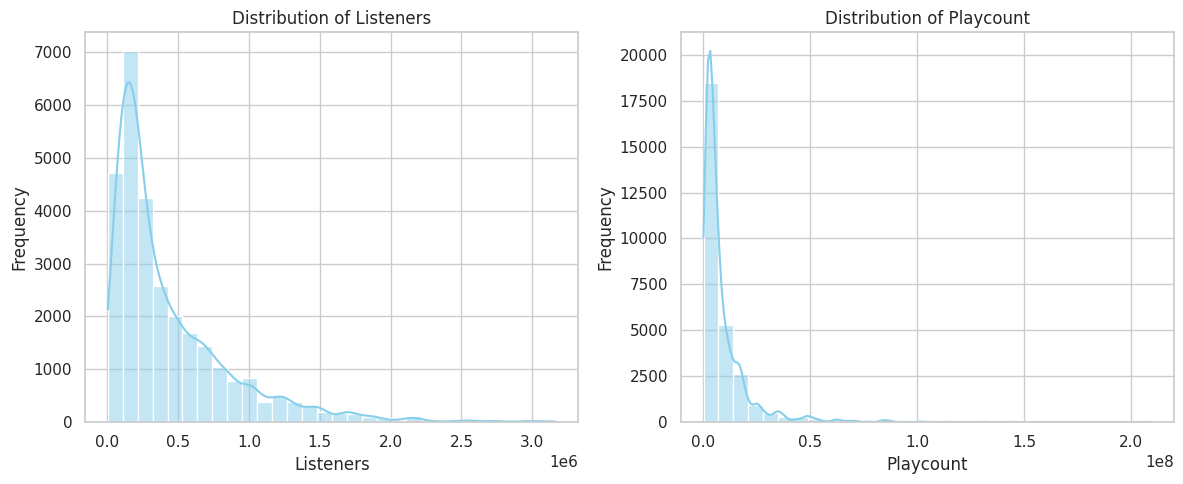

In [ ]:
sns.set(style="whitegrid")
numerical_columns = ['listeners', 'playcount']

# Create subplots for each feature
fig, axes = plt.subplots(1, len(numerical_columns), figsize=(12, 5))

# Plotting histograms and boxplots for each column
for i, col in enumerate(numerical_columns):
    # Histogram
    sns.histplot(album_data[col], kde=True, ax=axes[i], color="skyblue", bins=30)
    axes[i].set_title(f'Distribution of {col.capitalize()}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### 2. Top 10 artist by play count, listners, engagement ration
#### Findings - Artists like Coldplay and Rihanna have large listener bases but are absent from the engagement ratio chart, indicating casual or one-time listeners. Artists like BTS and Taylor Swift excel in both listeners and engagement, showcasing their ability to attract and maintain highly engaged audiences.

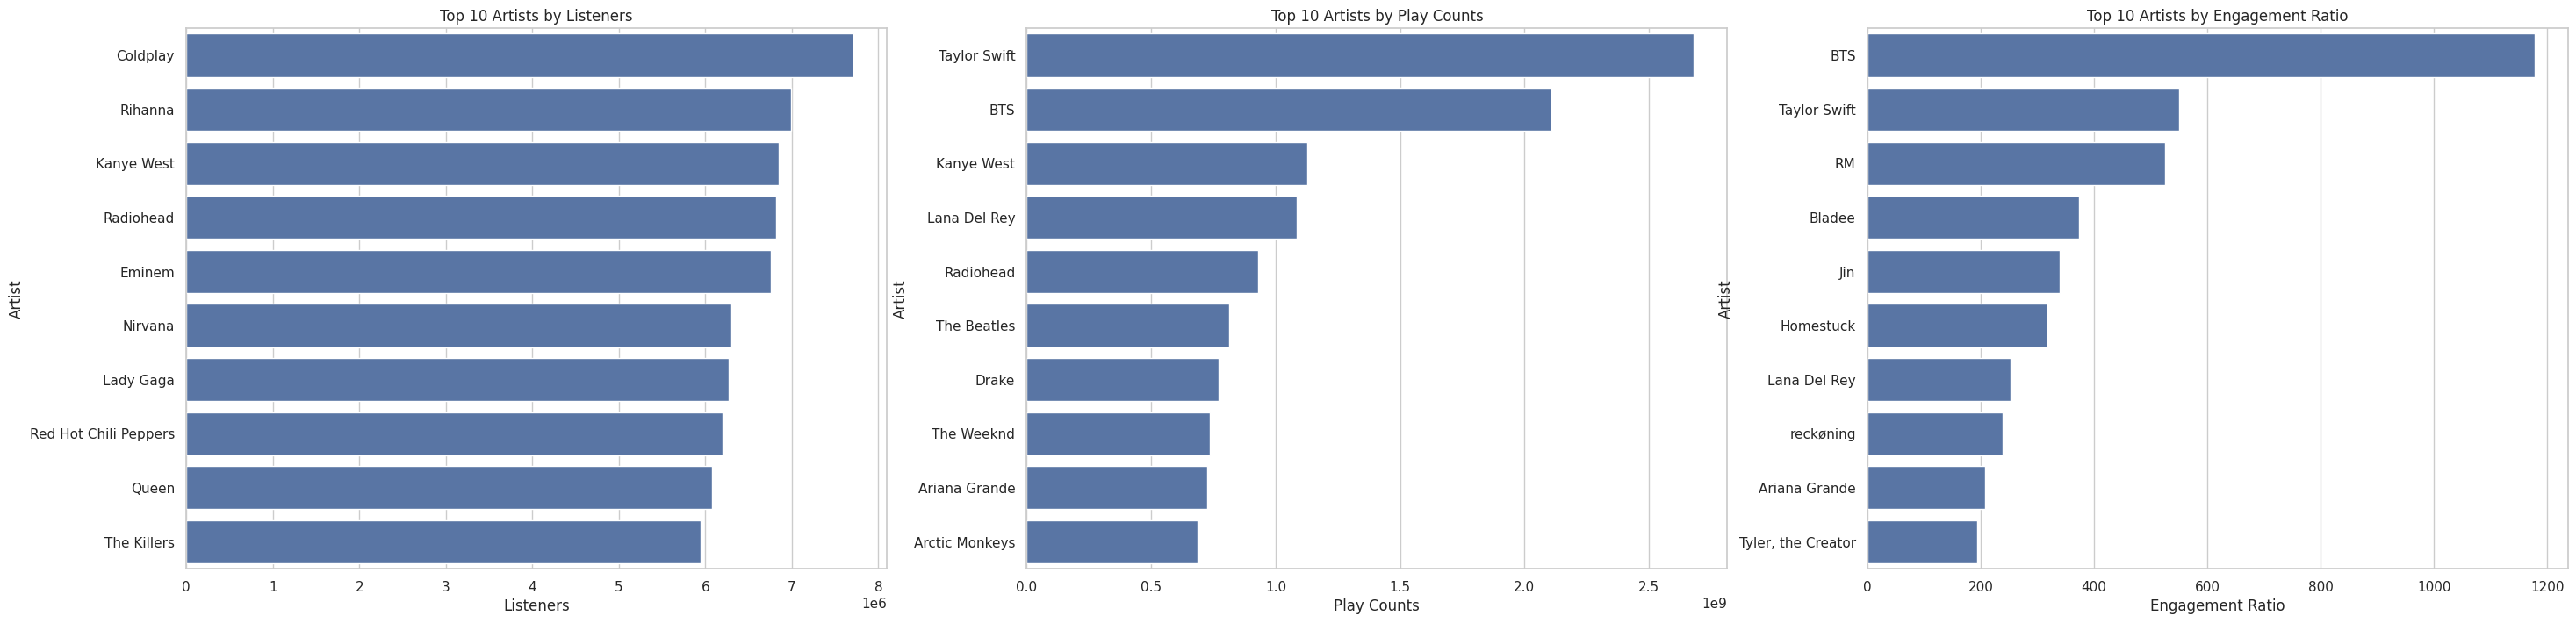

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(35, 8))
# Top 10 artists by listeners
top_listeners = artist_data.nlargest(10, 'listeners')
sns.barplot(x='listeners', y='Name', data=top_listeners, ax=axes[0])
axes[0].set_title('Top 10 Artists by Listeners')
axes[0].set_xlabel('Listeners')
axes[0].set_ylabel('Artist')

# Top 10 artists by play counts
top_play_counts = artist_data.nlargest(10, 'play_counts')
sns.barplot(x='play_counts', y='Name', data=top_play_counts, ax=axes[1])
axes[1].set_title('Top 10 Artists by Play Counts')
axes[1].set_xlabel('Play Counts')
axes[1].set_ylabel('Artist')

# Engagement Ratio
artist_data['engagement_ratio'] = artist_data['play_counts'] / artist_data['listeners']
top_engaged = artist_data.nlargest(10, 'engagement_ratio')
sns.barplot(x='engagement_ratio', y='Name', data=top_engaged)
axes[2].set_title('Top 10 Artists by Engagement Ratio')
axes[2].set_xlabel('Engagement Ratio')
axes[2].set_ylabel('Artist')
plt.show()


plt.tight_layout()
plt.show()

### 3. Common Tags given to album and artists by users
#### Findings - Albums are generally classified with their genre like Hip-Hop and rock. While it comes to artists, it depends on artist characteritcs like if users have seen the artist perform live or if artist is female or male vocalist.

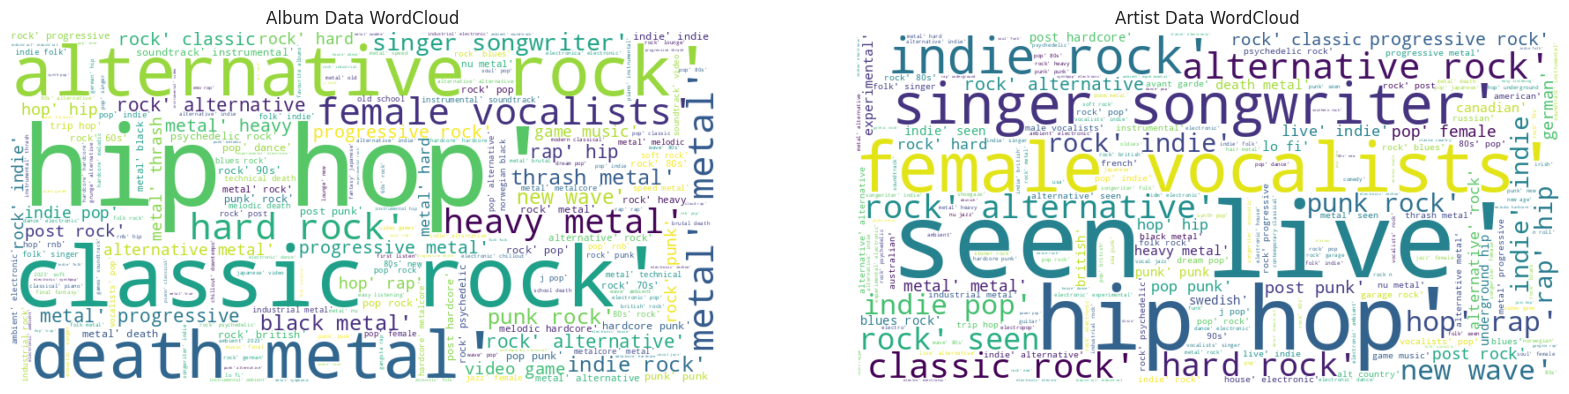

In [ ]:
# Generate word cloud for album_data
album_tag_text = ' '.join(album_data['tags'].str.replace(r"[\[\]',]", '').str.lower())
album_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(album_tag_text)

# Generate word cloud for artist_data
artist_tag_text = ' '.join(artist_data['tags'].str.replace(r"[\[\]',]", '').str.lower())
artist_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(artist_tag_text)

# Plot the word clouds side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(album_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Album Data WordCloud')

axes[1].imshow(artist_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Artist Data WordCloud')

plt.show()


### 4. Trend between listeners count and play count
#### Key Findings -  As listeners count ( no of unique listeners) increased the play count ( no of time a song has been played) also increases. Outliers with high play counts but low listeners are worth investigating as they may indicate a niche but highly engaged audience.


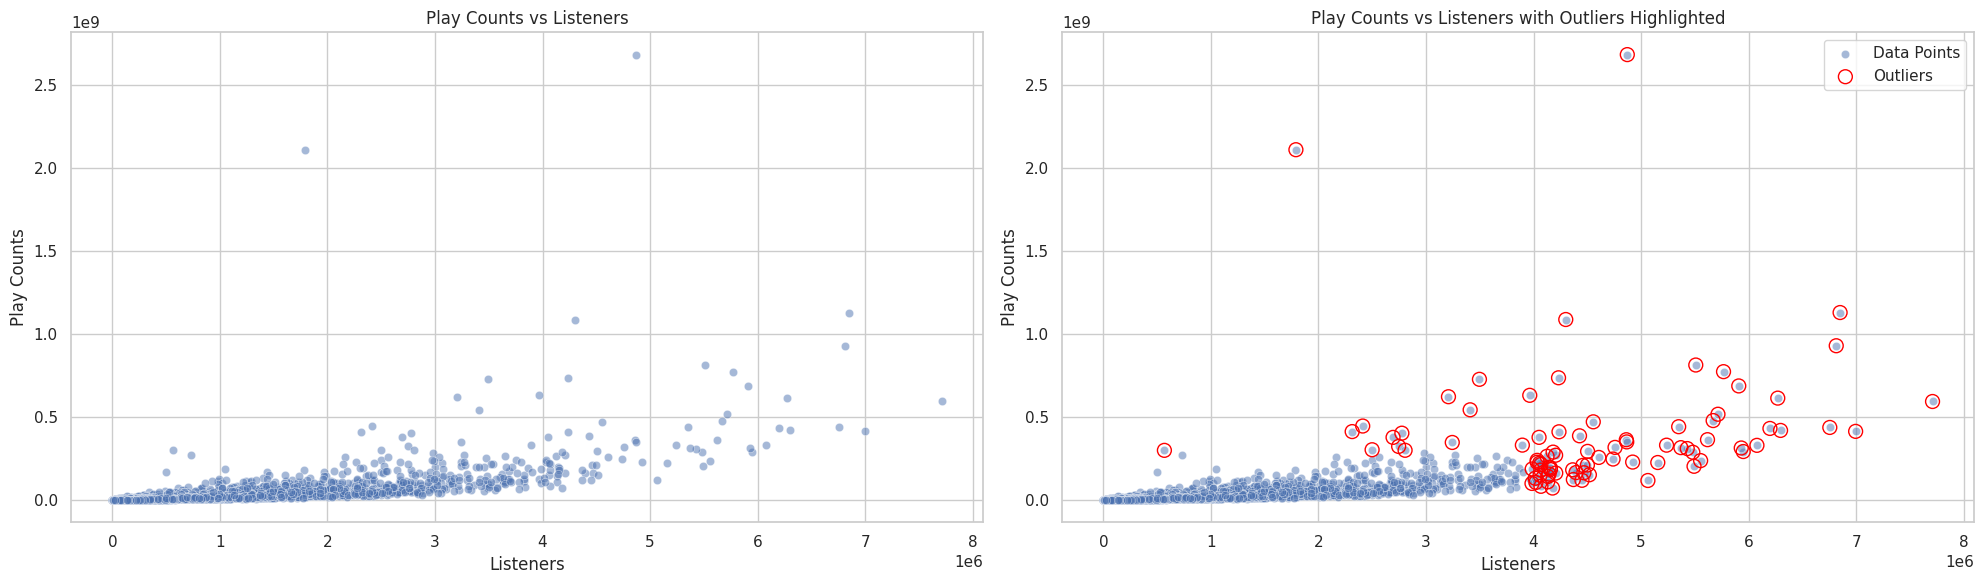

In [ ]:
# Calculate z-scores for listeners and play counts
artist_data['listeners_zscore'] = zscore(artist_data['listeners'])
artist_data['play_counts_zscore'] = zscore(artist_data['play_counts'])

# outliers as data points with z-scores > 5.5
outliers = artist_data[(np.abs(artist_data['listeners_zscore']) > 5.5) | (np.abs(artist_data['play_counts_zscore']) > 5.5)]

# Creating a horizontal layout for two scatter plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Scatter plot for Play Counts vs Listeners (without highlighting outliers)
sns.scatterplot(x='listeners', y='play_counts', data=artist_data, alpha=0.5, ax=axes[0])
axes[0].set_title('Play Counts vs Listeners')
axes[0].set_xlabel('Listeners')
axes[0].set_ylabel('Play Counts')

# Scatter plot for Play Counts vs Listeners with outliers highlighted
sns.scatterplot(x='listeners', y='play_counts', data=artist_data, alpha=0.5, label='Data Points', ax=axes[1])
axes[1].scatter(outliers['listeners'], outliers['play_counts'], edgecolor='red', facecolor='none', s=100, label='Outliers')
axes[1].set_title('Play Counts vs Listeners with Outliers Highlighted')
axes[1].set_xlabel('Listeners')
axes[1].set_ylabel('Play Counts')
axes[1].legend()

plt.tight_layout()
plt.show()


### 5. User data distribution by Country
#### Findings - Most data collected are from United Kingdom followed by United States, so data obtained will be have artist prominently popular in these countries

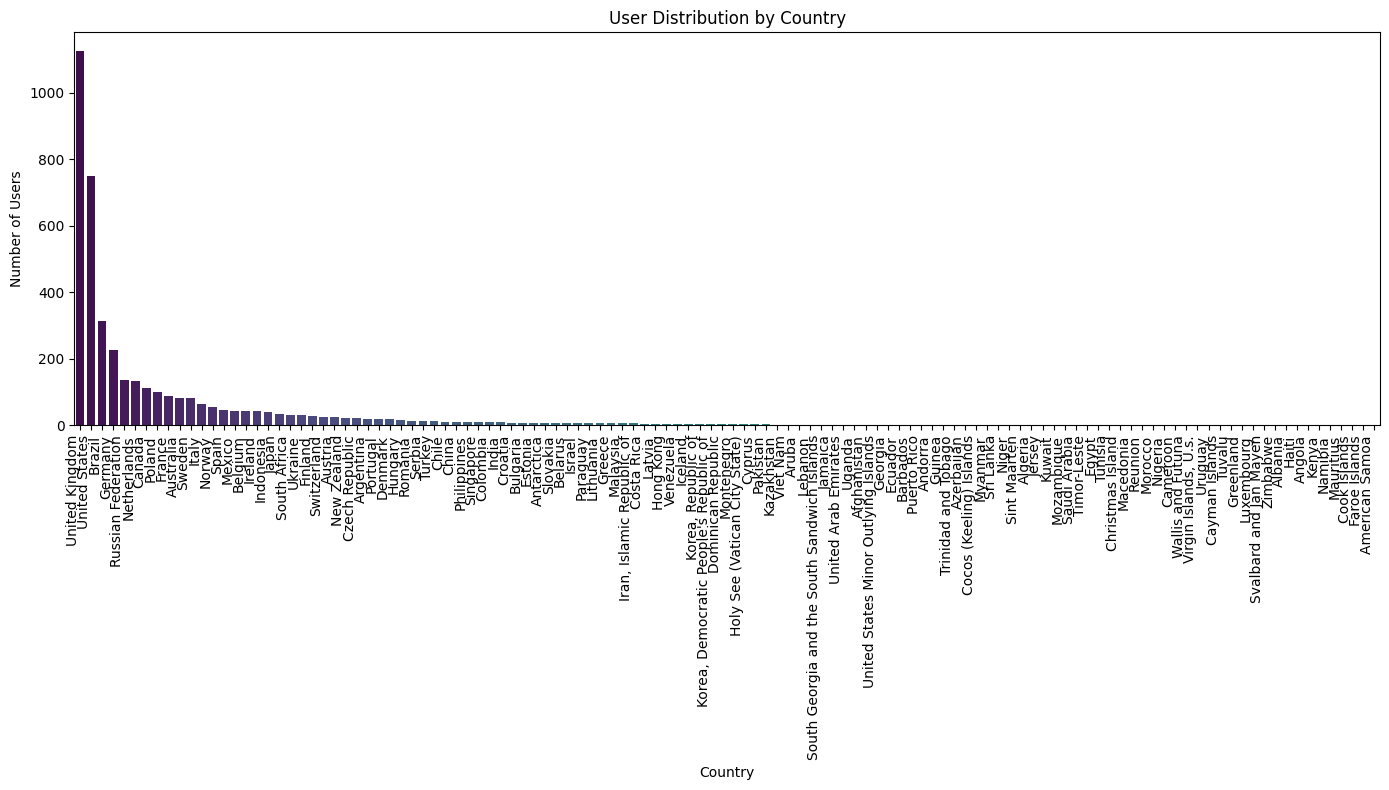

In [ ]:
# Drop rows where 'Country' is None or NaN
country_counts = user_data['Country'].dropna().value_counts()

plt.figure(figsize=(14, 8))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')

plt.title('User Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.xticks(rotation=90, ha='right')  # Rotate the labels and align them to the right
plt.tight_layout()
plt.show()


# Data Cleaning

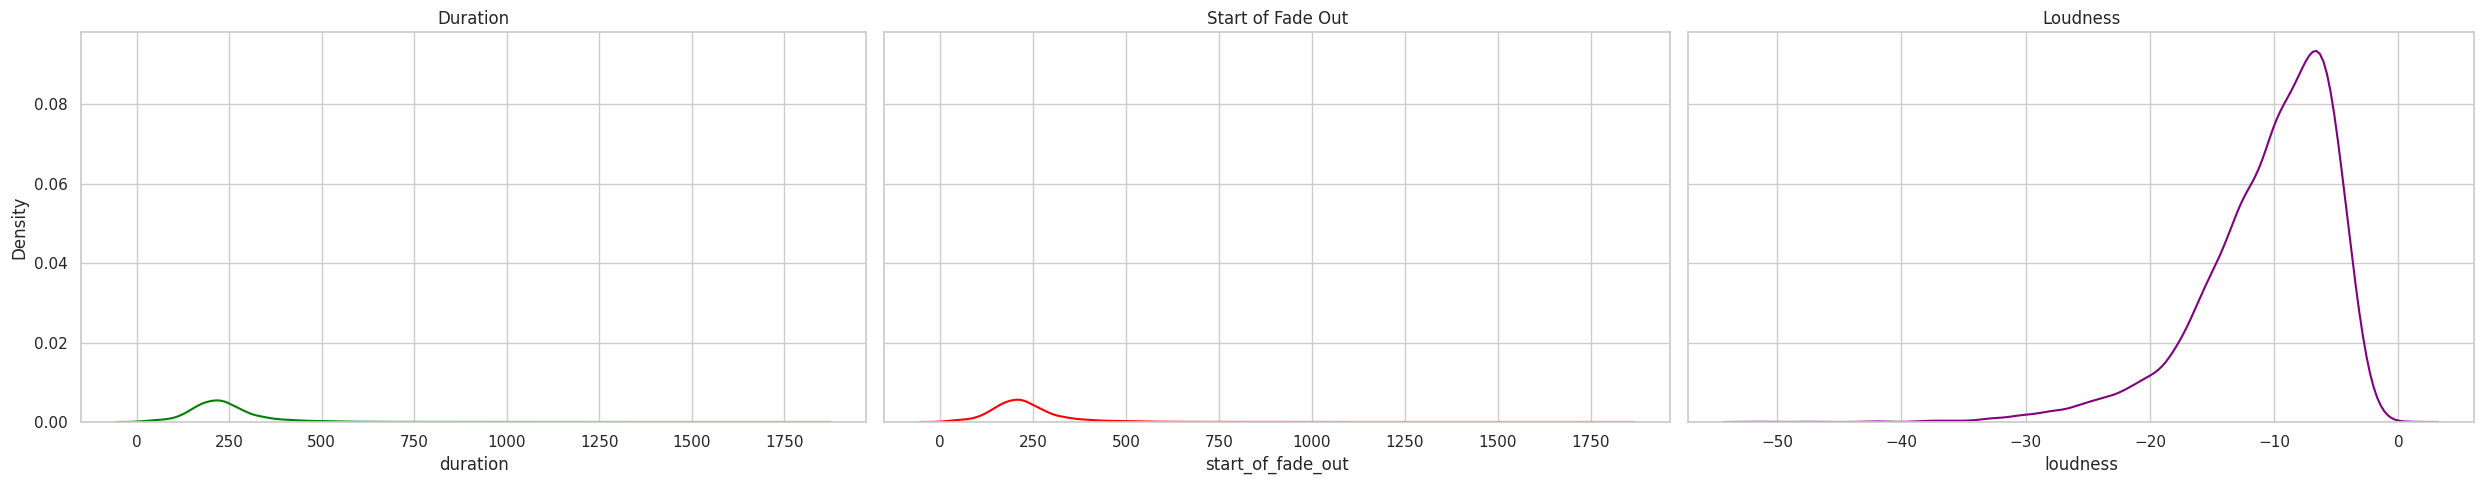

In [ ]:
# Create subplots with shared y-axis (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharey=True)


sns.kdeplot(msd_data['duration'], ax=axes[0], color='green')
axes[0].set_title('Duration')

sns.kdeplot(msd_data['start_of_fade_out'], ax=axes[1], color='red')
axes[1].set_title('Start of Fade Out')

sns.kdeplot(msd_data['loudness'], ax=axes[2], color='purple')
axes[2].set_title('Loudness')

# Set overall labels and layout
plt.tight_layout()
plt.show()


### Converting variables to right encoding for readability and dropping columns with lot of NAN values

In [ ]:
# Dropping multiple columns with NaN values
columns_to_drop = ['idx_similar_artists', 'idx_artist_terms', 'genre',
                   'analysis_sample_rate', 'energy', 'analyzer_version', 'danceability']
msd_data.drop(columns=columns_to_drop, inplace=True)
# Decoding specific columns
columns_to_decode = ['title', 'song_id', 'release', 'artist_name', 'artist_mbid', 'artist_id', 'track_id']
msd_data[columns_to_decode] = msd_data[columns_to_decode].applymap(lambda x: x.decode('utf-8'))

# Filter rows where specified columns have non-empty lists
columns_to_check = ['beat_start', 'beat_confidence', 'bar_confidence',
                    'sections_confidence', 'tatums_start']

for col in columns_to_check:
    msd_data = msd_data[msd_data[col].apply(lambda x: len(x)) > 0]


msd_data['artist_mbtags'] = msd_data['artist_mbtags'].apply(lambda x: ["Unknown"] if len(x) == 0 else [item.decode('utf-8') for item in x])
msd_data['artist_mbtags_counts'] = msd_data['artist_mbtags_counts'].apply(lambda x: [0] if len(x) == 0 else x)

# Machine Learning and Data Mining

# Model 1  Melodify clusterting based on embeddings

### The audio features of the Million Song Data are converted into embeddings using a Convolutional Neural Network (CNN). These embeddings are then clustered to form distinct groups.

In [ ]:
feature_columns = ["bar_confidence", "beat_confidence", "sections_confidence"]
df = msd_data[feature_columns]

def parse_and_pad(column, pad_length):
    sequences = df[column].tolist()
    return pad_sequences(sequences, maxlen=pad_length, padding='post', dtype='float32')

pad_length = 20
# Process each feature column
features = [parse_and_pad(col, pad_length) for col in feature_columns]
# Combine features into a single tensor
X = np.stack(features, axis=0)
print(X.shape)
X = X[..., np.newaxis]

print("Input shape:", X.shape)
X = np.moveaxis(X, 0, 1)


(3, 8765, 20)
Input shape: (3, 8765, 20, 1)


In [ ]:
n_features, sequence_length = X.shape[1:3]
embedding_size = 50

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(n_features, sequence_length, 1), padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(embedding_size)
])
model.compile(optimizer='adam', loss='mse')
y = np.random.rand(X.shape[0], embedding_size).astype(np.float32)
model.fit(X, y, epochs=20, batch_size=32)


Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1269
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0839
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0836
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0836
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0836
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0835
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0835
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0832
Epoch 9/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0834
Epoch 10/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0832
Epoch 11/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0830
Epoch 12/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0829
Epoch 13/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0831
Epoch 14/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0829
Epoch 15/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

In [ ]:
# Generate embeddings
embeddings = model.predict(np.transpose(X, (0, 2, 1, 3)))
print("Embeddings shape:", embeddings.shape)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Embeddings shape: (8765, 50)


In [ ]:
model.save('song_embedding_model.keras')
embedding_df = pd.DataFrame(embeddings)
embedding_df.to_csv("song_embeddings.csv", index=False)

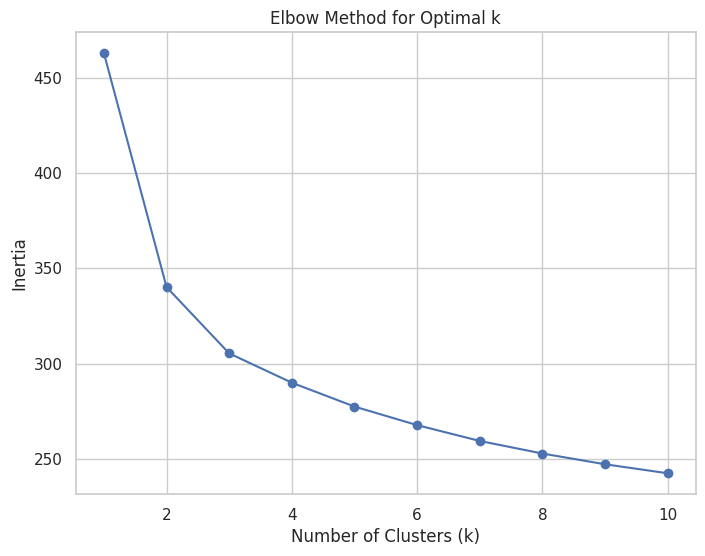

In [ ]:
embeddings = pd.read_csv("song_embeddings.csv").values
# Determining the optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


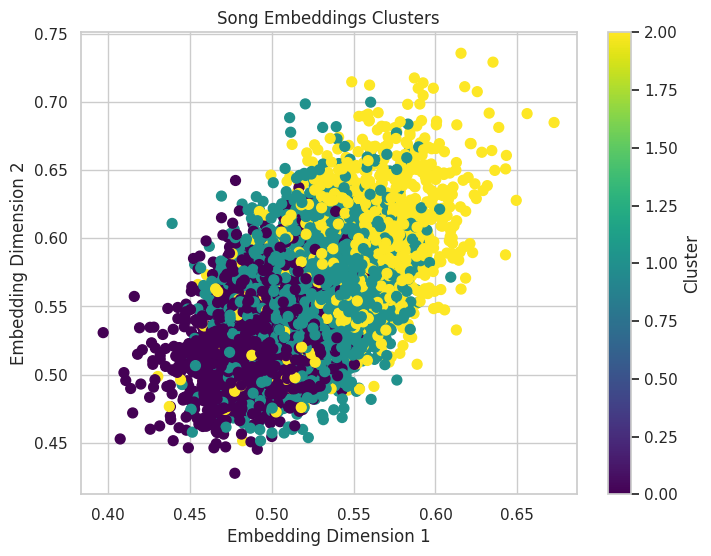

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
clusters = kmeans.fit_predict(embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('Song Embeddings Clusters')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

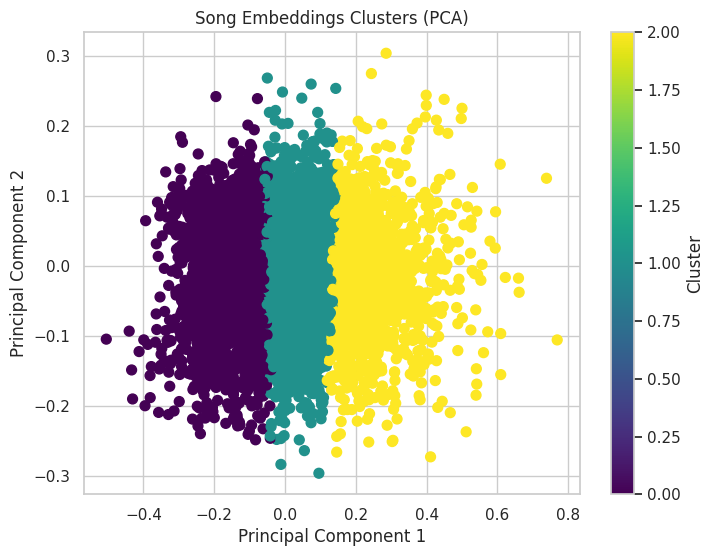

In [ ]:
# Using PCA to convert n dimension embedding into 2-D vector
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('Song Embeddings Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
silhouette_avg = silhouette_score(embeddings, clusters)

print(f"The average silhouette score is: {silhouette_avg}")
song_clusters = pd.DataFrame({'title': msd_data['title'], 'cluster': clusters})

# Print 5 random song names from each cluster
for cluster_id in range(k):
    cluster_songs = song_clusters[song_clusters['cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")

    # Handle cases where a cluster might have fewer than 5 songs
    num_songs_to_print = min(10, len(cluster_songs))

    random_songs = cluster_songs.sample(n=num_songs_to_print, random_state=0) # Set random_state for reproducibility
    for index, row in random_songs.iterrows():
        print(row['title'])
    print("\n")

The average silhouette score is: 0.14425946753104535
Cluster 0:
Autores Anonimos
Guitarra Dimelo Tu
Raining On The Cold_ Cold Ground
Yo Mouth (Skit)
Slap U Around
Here Comes The Big Parade
The Dark Road
Fair Diana
Only You
The Dynamo Of Volition [From An All Night Session]


Cluster 1:
Muh- F***a
Flamingos
Been Sick Lung
Je n'irai pas ailleurs
One Hour Empire
Talk
Make This Love Last
The One Piece Puzzle
Guardian Angel
Reason


Cluster 2:
Vibrators
Forming
House Full Of Bullets
Go On
I'll Be Your Light (Ian Nieman Remix)
Requiem Mass_ K. 626_ 1791: Agnus Dei (Larghetto) (Mozart)
Music Reach (1/2/3/4) (Remastered)
You Are Allowed 20 Birthday Parties (Album)
Up On That Cloud
Leader (Album Version)




In [ ]:
# Find the index of "L'idole des femmes"

target_song_index = msd_data[msd_data['title'] == "L.A. Arteest Café"].index

if not target_song_index.empty:
    target_song_index = target_song_index[0]
    # Scale the embeddings
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    # Calculate cosine similarity
    similarity_scores = cosine_similarity([scaled_embeddings[target_song_index]], scaled_embeddings)
    # Find the index of the most similar song (excluding the target song itself)
    most_similar_index = np.argsort(similarity_scores[0])[-2]
    # Get the title of the most similar song
    most_similar_song_title = msd_data.loc[most_similar_index, 'title']
    print(f"The closest song to 'Lady Marmalade' is: {most_similar_song_title}")

else:
    print("'L'idole des femmes' not found in the dataset.")

The closest song to 'Lady Marmalade' is: Finding My Way


# Model 2 - Using XGBoost model for recomendations
### User preferences based on tags are used to recommend songs. The tags are converted into embeddings using a Sentence Transformer. These embeddings are then utilized to cluster the data into 10 groups. Finally, XGBoost is employed to predict songs corresponding to the given tags.

In [ ]:
def preprocess_text(text):
  if pd.isna(text):
    return []
  tokens = word_tokenize(text.lower())
  tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words]
  return tokens

In [ ]:
artist = artist_data[:1000]
artist['summary_tokens'] = artist['summary'].apply(preprocess_text)
artist['top_album_tokens'] = artist['summary'].apply(preprocess_text)
artist['top_songs_tokens'] = artist['summary'].apply(preprocess_text)
corpus = (
    artist['summary_tokens'].tolist() +
    artist['top_album_tokens'].tolist() +
    artist['top_songs_tokens'].tolist()
)

# usng Word2Vec for conversion to vector
word2Vec_model = Word2Vec(
    sentences = corpus,
    vector_size = 100,
    window = 5,
    workers = 1,
    sg = 1
)
def get_feature_vector(token, models):
  vectors = [models.wv[word] for word in token if word in models.wv]
  if len(vectors) == 0:
      return np.zeros(models.vector_size)
  return np.mean(vectors, axis = 0)

artist['summary_vector'] = artist['summary_tokens'].apply(lambda x: get_feature_vector(x, word2Vec_model))
artist['top_album_vector'] = artist['top_album_tokens'].apply(lambda x: get_feature_vector(x, word2Vec_model))
artist['top_song_vector'] = artist['top_songs_tokens'].apply(lambda x: get_feature_vector(x, word2Vec_model))


In [ ]:
similar_artist_list = artist['similar_artist'].tolist()
model = Word2Vec(sentences = similar_artist_list, vector_size = 100,
                 window = 5, min_count=1, sg = 1, workers=4)
artist['similar_artist_embedding'] = artist['similar_artist'].apply(lambda x: get_feature_vector(x, model))

In [ ]:
# inverse transformer so model give more weightage to artist will lesser play counts
artist['listeners'] = 1 / (artist['listeners'] + 1e-6)
artist['play_counts'] = 1 / (artist['play_counts'] + 1e-6)

In [ ]:
# top 5 tags of each artist is taken into consideration and unique tag list is made
artist['tags'] = artist['tags'].apply(lambda x: x[:5] if isinstance(x, list) else x)
artist['tags'] = artist['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
artist['tags'] = artist['tags'].apply(lambda x: list(set(tag.lower() for tag in x)))
unique_tags = set(tag for tag_list in artist['tags'] for tag in tag_list)
unique_tags = list(unique_tags)

In [ ]:
# loading the Sentence Transformer
model = SentenceTransformer('all-MiniLM-L6-v2')

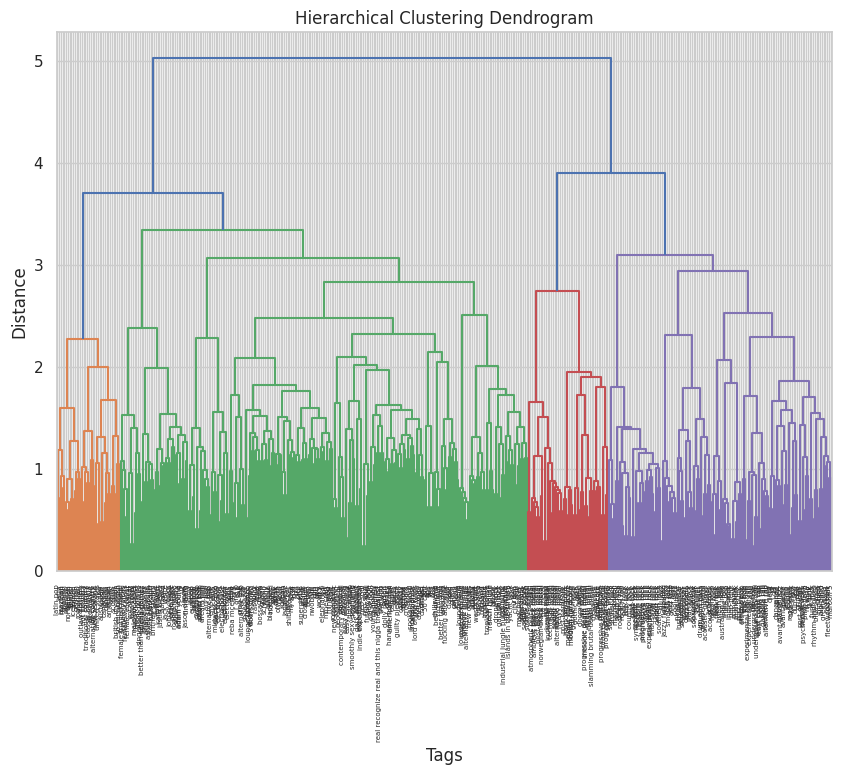

In [ ]:
tag_embeddings = model.encode(unique_tags)
cos_sim = cosine_similarity(tag_embeddings)
linkage_matrix = linkage(tag_embeddings, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=unique_tags, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Tags")
plt.ylabel("Distance")
plt.show()


In [ ]:
# using clustering to obtain 10 clusters that will divide songs into groups
clusterer = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')
clusters = clusterer.fit_predict(tag_embeddings)
tag_clusters = {tag: cluster for tag, cluster in zip(unique_tags, clusters)}
result = {}
for key, value in tag_clusters.items():
    if value not in result:
      result[value] = []
    result[value].append(key)

In [ ]:
# List of genre names
result1 = {}
genres = ['hip hop', 'romantic', 'lounge music', 'instrumental', 'singer',
          'rock', 'pop', 'country music', 'hardcore', 'metal']

# Create result1 by mapping genre names to the corresponding values from result and according to count of tags in each cluster
result1 = {genre: result[idx] for idx, genre in enumerate(genres)}
for genre, values in result1.items():
    print(f"'{genre}' has {len(values)} values")

'hip hop' has 68 values
'romantic' has 131 values
'lounge music' has 39 values
'instrumental' has 29 values
'singer' has 39 values
'rock' has 30 values
'pop' has 23 values
'country music' has 36 values
'hardcore' has 26 values
'metal' has 20 values


<Axes: ylabel='mapped_cluster'>

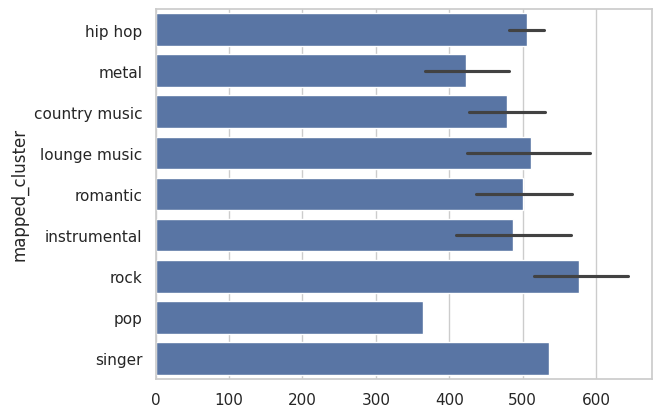

In [ ]:
tag_to_cluster = {tag : cluster for cluster, tags in result1.items() for tag in tags}
def map_tag_to_cluster(tag_list):
  preference_order = ['metal', 'pop', 'instrumental', 'rock', 'country music','instrumental', 'country music',  'lounge music', 'singer', 'hip hop', 'romantic']
  mapped_clusters = [tag_to_cluster[tag] for tag in tag_list if tag in tag_to_cluster]
  mapped_clusters = list(set(mapped_clusters))
  for cluster in mapped_clusters:
    if cluster in preference_order:
      return str(cluster)
artist['mapped_cluster'] = artist['tags'].apply(map_tag_to_cluster)
sns.barplot(artist['mapped_cluster'])

In [ ]:
# converting to correct labels
label_encoder = LabelEncoder()
artist['mapped_cluster_encoded'] = label_encoder.fit_transform(artist['mapped_cluster'])

In [ ]:
artist.drop(columns=['MBID', 'similar_artist', 'tags', 'summary', 'top_album', 'summary_tokens', 'top_album_tokens', 'top_songs_tokens', 'mapped_cluster', 'top_songs'], inplace=True)
features = np.hstack([
    np.vstack(artist['summary_vector']),
    np.vstack(artist['top_album_vector']),
    np.vstack(artist['top_song_vector']),
    np.vstack(artist['similar_artist_embedding']),
    artist[['listeners', 'play_counts']].values
    ])

target = artist['mapped_cluster_encoded'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

from xgboost import XGBClassifier
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softmax',  # Use 'multi:softprob' for probabilities
    num_class=10,  # Number of unique tags
    random_state=42
)
model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=10,
              num_parallel_tree=None, ...)

In [ ]:
# Predictions
from sklearn.metrics import accuracy_score, f1_score, classification_report
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))


Accuracy: 0.605
F1 Score: 0.4826536655526884
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.63      0.97      0.76       120
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         8
           4       0.33      0.25      0.29        12
           6       0.50      0.11      0.18         9
           7       0.00      0.00      0.00        18

    accuracy                           0.60       200
   macro avg       0.21      0.19      0.18       200
weighted avg       0.42      0.60      0.48       200



In [ ]:
# given a tag it will give top 10 artist belongs to those genre, the result obtained shows artist with ranging playcount showing the robustness of model
tag = 1 # romantics
ranked_artists_names = []
tag_probs = model.predict_proba(X_test)
ranked_artists = np.argsort(-tag_probs[:, tag])  # Rank artists by probabilities
top_name = [artist['Name'].iloc[i] for i in ranked_artists[:10]]
ranked_artists_names.extend(top_name)
print("Top Recommended Artists for Tag", tag, ":", ranked_artists_names)


Top Recommended Artists for Tag 1 : ['Panic! at the Disco', 'Bon Jovi', 'U2', 'Miley Cyrus', 'The Offspring', 'The Flaming Lips', 'Corinne Bailey Rae', 'Zara Larsson', 'The Fray', 'Sufjan Stevens']


In [ ]:
def precision_at_k(y_true, y_pred, k):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] in y_pred[i][:k]:
            correct += 1
    return correct / len(y_true)

precision = precision_at_k(y_test, [np.argsort(-probs) for probs in tag_probs], k=5)
print("Precision@5:", precision)


Precision@5: 0.925


# Model 3 - Using RNN to understand similarity between songs
### The model leverages a Recurrent Neural Network (RNN) to capture patterns in the audio features and predict the similarity between songs.

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.9912 - val_loss: 0.0332
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0812 - val_loss: 0.0162
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0566 - val_loss: 0.0176
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161
Test Loss: 0.015585361048579216


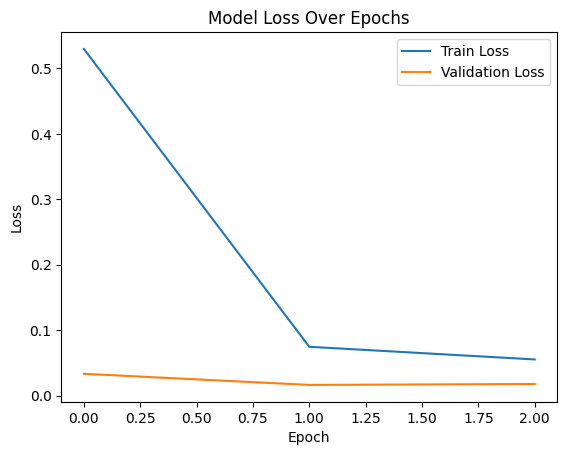

                     Song        Most_Similar_Song
0     b"I Didn't Mean To"            b'Murder One'
1     b"I Didn't Mean To"        b"I'll Be Better"
2     b"I Didn't Mean To"        b'Say How I Feel'
3     b"I Didn't Mean To"                 b'Drive'
4     b"I Didn't Mean To"  b'Un Amor En El Olvido'
...                   ...                      ...
8815   b'Les Grande Bois'             b'Megatrend'
8816   b'Les Grande Bois'              b'Izgaryam'
8817   b'Les Grande Bois'          b'Voodoo Chile'
8818   b'Les Grande Bois'        b'All Night Long'
8819   b'Les Grande Bois'      b'Hole In The Coal'

[8820 rows x 2 columns]


In [ ]:
# Features
features = ['segments_confidence', 'segments_loudness_max', 'bar_confidence',
            'beat_confidence', 'tempo', 'loudness', 'key', 'mode']

df_selected = msd_data[features].copy()

# Handle missing values
numeric_columns = df_selected.select_dtypes(include=['float64', 'int32'])
df_selected[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.mean())

categorical_columns = df_selected.select_dtypes(include=['object'])
label_encoder = LabelEncoder()

# Encoding categorical columns like 'key' and 'mode'
for column in categorical_columns.columns:
    df_selected[column] = label_encoder.fit_transform(df_selected[column].astype(str))

# Normalizing the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(df_selected)  # Normalizing the feature data

# Applying PCA for dimensionality reduction (reduce to 2 components for visualization)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_normalized)

# Spliting the dataset into training (80%) and testing (20%)
X_train, X_test = train_test_split(X_reduced, test_size=0.2, random_state=42)

# Creating an RNN model for the task
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(X_train.shape[1], 1)))
model.add(layers.LSTM(128, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))  # Dropout to prevent overfitting
model.add(layers.LSTM(64, activation='relu'))
model.add(layers.Dropout(0.2))  # Dropout to prevent overfitting
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(X_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

# Reshaping the data for RNN input (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Set up EarlyStopping callback to stop training as soon as the loss reaches its lowest level
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
history = model.fit(X_train_reshaped, X_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Step 8: Evaluate the model on the test set
test_loss = model.evaluate(X_test_reshaped, X_test)
print(f"Test Loss: {test_loss}")

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Function to calculate similarity between songs
def get_similarity_matrix(X_reduced):
    return cosine_similarity(X_reduced)

# Get similarity matrix for the entire dataset
similarity_matrix = get_similarity_matrix(X_reduced)

# Get true similar songs from the similarity matrix (ground truth)
# For simplicity, let's define the ground truth as the top 5 similar songs based on cosine similarity
ground_truth_similar_songs = []
for i in range(len(X_test)):
    song_similarities = similarity_matrix[i]
    similar_songs = song_similarities.argsort()[-6:-1]  # Excluding the song itself (top 5 similar songs)
    ground_truth_similar_songs.append(similar_songs)

# Recommend similar songs based on the model's similarity matrix (predictions)
def recommend_similar_songs(song_idx, similarity_matrix, n=5):
    similar_indices = similarity_matrix[song_idx].argsort()[-(n+1):-1]
    return similar_indices

#  Get recommendations for all songs in the test set
recommendations = []
for song_idx in range(len(X_test)):  # Loop through all test set songs
    similar_songs = recommend_similar_songs(song_idx, similarity_matrix, n=5)
    recommendations.append(similar_songs)

#  Display the recommendations (song titles instead of indices)
# Assuming `data` has a column 'title' that contains the song titles
song_titles = msd_data['title'].tolist()

# Create a DataFrame for song titles and their top similar songs
similarity_data = []
for idx, recs in enumerate(recommendations):
    song_title = song_titles[idx]
    for rec_idx in recs:
        similar_song_title = song_titles[rec_idx]
        similarity_data.append([song_title, similar_song_title])

# Create a DataFrame
similarity_df = pd.DataFrame(similarity_data, columns=['Song', 'Most_Similar_Song'])

# Display the DataFrame
print(similarity_df)

 # Ensure the number of test samples is consistent
# Ensure that the number of test samples is consistent
num_test_samples = len(ground_truth_similar_songs)  # Ground truth length (test set size)

# Trim recommendations to match the number of test samples
recommendations_trimmed = recommendations[:num_test_samples]


In [ ]:
similarity_df_matrix = pd.DataFrame(similarity_matrix, columns=msd_data['title'], index=msd_data['title'])

# Print the similarity matrix
print("Similarity Matrix (Top 10 Songs Example):")
similarity_df_matrix.head(10)

Similarity Matrix (Top 10 Songs Example):


title,"b""I Didn't Mean To""",b'Soul Deep',b'Amor De Cabaret',b'Something Girls',b'Face the Ashes',b'The Moon And I (Ordinary Day Album Version)',b'Keepin It Real (Skit)',b'Drop of Rain',b'Pink World',b'Insatiable (Instrumental Version)',...,b'20.000 Seconds',b'Pastel',b'Cedar and Clay (World)',b'Red Sails In The Sunset',b'Smoke In The Air (A Cappella)',b'Qu Ni De Hun Li',"b""(The Best Part Of) Breakin' Up""",b'Kapitel 4',b'IRM',b'Look Thru My Eyes'
title,,,,,,,,,,,,,,,,,,,,,
"b""I Didn't Mean To""",1.000000,0.071671,0.999571,-0.909706,0.658429,0.792134,0.341277,0.998648,0.717649,0.022495,...,0.598210,0.673290,0.681869,0.884369,0.032616,0.890122,0.973730,-0.722984,-0.724692,-0.987510
b'Soul Deep',0.071671,1.000000,0.042441,-0.479385,0.797898,0.665550,-0.913086,0.019722,-0.643179,0.998788,...,-0.756404,0.785733,-0.680723,-0.402204,-0.994560,-0.390754,-0.157334,0.637271,0.635361,-0.227925
b'Amor De Cabaret',0.999571,0.042441,1.000000,-0.897160,0.636113,0.773927,0.368648,0.999742,0.737729,-0.006783,...,0.621413,0.651355,0.702991,0.897655,0.061861,0.903082,0.979978,-0.742899,-0.744554,-0.982475
b'Something Girls',-0.909706,-0.479385,-0.897160,1.000000,-0.911514,-0.974058,0.079861,-0.886889,-0.363666,-0.435611,...,-0.211437,-0.919525,-0.316554,-0.610681,0.385361,-0.620510,-0.791252,0.370820,0.373118,0.963769
b'Face the Ashes',0.658429,0.797898,0.636113,-0.911514,1.000000,0.980937,-0.482750,0.618411,-0.051624,0.767264,...,-0.209244,0.999802,-0.101577,0.230969,-0.730768,0.243085,0.469749,0.043941,0.041468,-0.768787
b'The Moon And I (Ordinary Day Album Version)',0.792134,0.665550,0.773927,-0.974058,0.980937,1.000000,-0.303366,0.759334,0.143426,0.628011,...,-0.015232,0.984613,0.093679,0.415636,-0.584186,0.426948,0.632344,-0.151034,-0.153480,-0.878404
b'Keepin It Real (Skit)',0.341277,-0.913086,0.368648,0.079861,-0.482750,-0.303366,1.000000,0.389680,0.899512,-0.932048,...,0.957384,-0.465211,0.920265,0.740578,0.950594,0.732140,0.546348,-0.896125,-0.895023,-0.188919
b'Drop of Rain',0.998648,0.019722,0.999742,-0.886889,0.618411,0.759334,0.389680,1.000000,0.752882,-0.029509,...,0.639060,0.633941,0.718974,0.907440,0.084530,0.912610,0.984251,-0.757922,-0.759535,-0.977984
b'Pink World',0.717649,-0.643179,0.737729,-0.363666,-0.051624,0.143426,0.899512,0.752882,1.000000,-0.680085,...,0.987361,-0.031721,0.998745,0.959740,0.719441,0.956163,0.857373,-0.999970,-0.999948,-0.598965


# Model 4 Using random forest to decide the feature importance
### A Random Forest model is used to identify the importance of various features. To optimize the split values of the features, K-Nearest Neighbors (KNN) is applied to minimize the error.

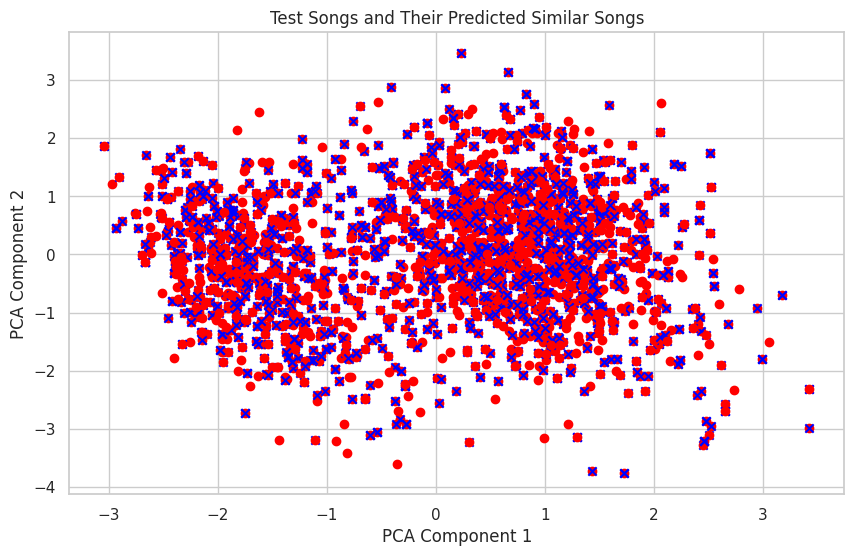

In [ ]:
features = ['segments_confidence', 'segments_loudness_max', 'bar_confidence',
            'beat_confidence', 'tempo', 'loudness', 'key', 'mode']  # Use all features


df_selected = msd_data[features].copy()

numeric_columns = df_selected.select_dtypes(include=['float64', 'int32'])
df_selected[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.mean())

# Handle categorical columns by filling missing values with the mode
categorical_columns = df_selected.select_dtypes(include=['object'])
label_encoder = LabelEncoder()

# Encoding categorical columns like 'key' and 'mode'
for column in categorical_columns.columns:
    df_selected[column] = label_encoder.fit_transform(df_selected[column].astype(str))


scaler = StandardScaler()
X_normalized = scaler.fit_transform(df_selected)

# Apply PCA for dimensionality reduction (reduce to 2 components for visualization)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_normalized)

# Split the dataset into training (80%) and testing (20%)
X_train, X_test = train_test_split(X_reduced, test_size=0.2, random_state=42)

# Train the Random Forest model to identify important features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, X_train)

# Use KNN to find similar songs based on all features
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, X_train)

# Find similar songs using KNN based on all features for each test song
similar_songs = knn_model.kneighbors(X_test, n_neighbors=5)

# Create a DataFrame to store the test song and its similar songs
similarity_data = []

# Iterate over each test song to collect its top 5 similar songs
for i, song_index in enumerate(range(len(X_test))):
    similar_song_indices = similar_songs[1][i]
    similar_song_titles = msd_data['title'].iloc[similar_song_indices].tolist()

    # Prepare the data for this test song
    similarity_data.append({
        'Test Song': msd_data['title'].iloc[song_index],
        'Predicted Top 1 Similar Song': similar_song_titles[0],
        'Predicted Top 2 Similar Song': similar_song_titles[1],
        'Predicted Top 3 Similar Song': similar_song_titles[2],
        'Predicted Top 4 Similar Song': similar_song_titles[3],
        'Predicted Top 5 Similar Song': similar_song_titles[4]
    })

#Convert the similarity data into a DataFrame
similarity_df = pd.DataFrame(similarity_data)

# Visualizing the similarity of songs: Create a scatter plot of test songs and their closest similar songs
plt.figure(figsize=(10, 6))
for idx, similar_song_indices in enumerate(similar_songs[1]):
    # Plot the test song
    plt.scatter(X_test[idx, 0], X_test[idx, 1], color='red', marker='o', label=f'Test Song {idx}')

    # Plot the similar songs (ensure indices are within bounds of X_test)
    for similar_song_idx in similar_song_indices:
        if similar_song_idx < len(X_test):
            plt.scatter(X_test[similar_song_idx, 0], X_test[similar_song_idx, 1], color='blue', marker='x')

plt.title('Test Songs and Their Predicted Similar Songs')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
#plt.legend(loc='upper right')
plt.show()


In [ ]:
similarity_df

,Test Song,Predicted Top 1 Similar Song,Predicted Top 2 Similar Song,Predicted Top 3 Similar Song,Predicted Top 4 Similar Song,Predicted Top 5 Similar Song
0,I Didn't Mean To,Die berüehmte drü Wörtli,Let It Be Me,Voy A Olvidarme,Rock The House (Explicit),Everything Your Heart Desires
1,Soul Deep,Sk8 Tough,Mountains Of Mourne,Battle Of The Tom Tom,Argument,Still
2,Amor De Cabaret,Buried Alive In The Blues,Midnight In Memphis,Ring The Alarm,Hound Dog,À Mon Avis
3,Something Girls,Siri,The Blood Covers It All (Live),Fefita,Don't Stop The Music (Streetlight Album Version),Head Hunter
4,Face the Ashes,Memorabilia,Le Roi A Fait Battre Tambour,Minha Namorada,Adeste fideles,Destroy Babylon
...,...,...,...,...,...,...
1748,Jacques Your Body (Make Me Sweat)/ Sounds Of W...,Atom x,Hold Me While I Cry,Pocket Full Of Stars,Mumbling or hearing loss?,The Invasion (Aka Black Wa Da Da)
1749,Over The Edge,Cha Cha Brasilia,The Sun Shine Down My Way,Un jour aux courses: Who's That Man,Jezebel,La Marca De Tus Labios
1750,Les Grande Bois,Missing (Olivier Berger Mix),Ghost of the Ocean (Live),China,Everyone make love,Dunn's Revenge
1751,All For Nothing,Lost In The Future,For You Mom & Dad,Enclosed_ One Broken Heart,Hippa To Da Hoppa [Explicit Version],All Over Me


# Model 5 Tag to Word2Vec Embedding
### This model averages the Word2Vec embeddings of keywords to generate a song vector, representing the song based on its associated tags.

In [ ]:
# get the unique tags from all artists and albums
unique_tags = set()
for tags in artist_data['tags']:
    val = tags.replace('[', '').replace(']', '').replace("'", '').split(', ')
    unique_tags.update(val)

for tags in album_data['tags']:
    val = tags.replace('[', '').replace(']', '').replace("'", '').split(', ')
    unique_tags.update(val)

print(len(unique_tags))


4049


In [ ]:
# Load the pre-trained Word2Vec model
try:
    model = api.load('word2vec-google-news-300')
except Exception as e:
    print(f"Error loading word2vec model: {e}")
    print("Trying to download the model...")
    model = api.load('word2vec-google-news-300')


def get_embedding(tags):
    embeddings = []
    for tag in word_tokenize(tags):
      try:
        embeddings.append(model[tag])
      except KeyError:
          # Handle words not in vocabulary (e.g., use a zero vector or a special token)
          embeddings.append(np.zeros(300))
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300)


album_data['tag_embedding'] = album_data['tags'].apply(lambda x: get_embedding(x.replace('[', '').replace(']', '').replace("'", '')))
artist_data['tag_embedding'] = artist_data['tags'].apply(lambda x: get_embedding(x.replace('[', '').replace(']', '').replace("'", '')))

[==================================================] 100.0% 1662.8/1662.8MB downloaded


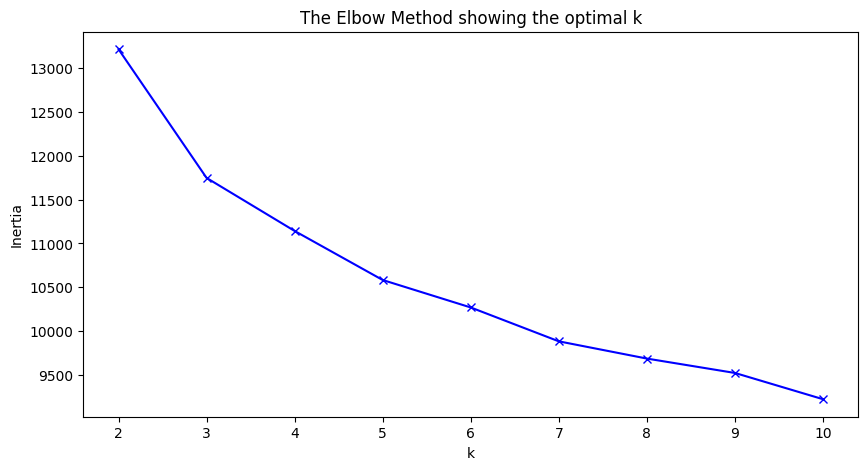

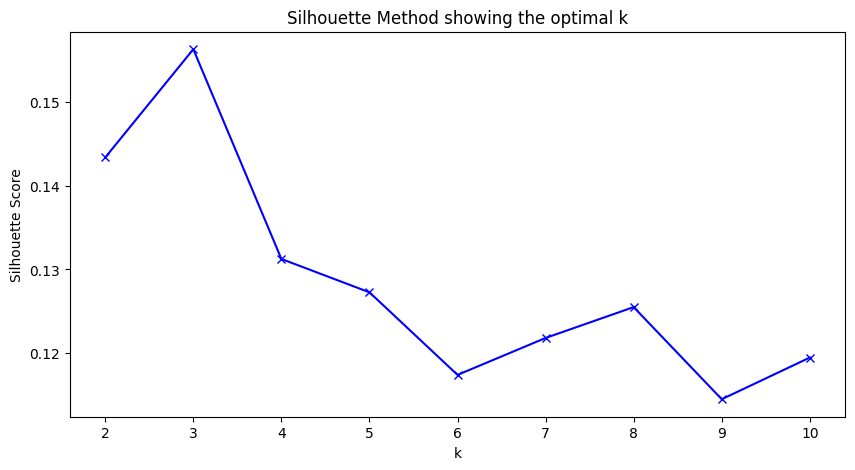

In [ ]:
# Combine tag embeddings from albums and artists
tag_embeddings = album_data['tag_embedding'].tolist()

# Determine optimal k using the elbow method
inertia = []
silhouette_avg = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(tag_embeddings)
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score
    cluster_labels = kmeans.labels_
    if len(np.unique(cluster_labels)) > 1:
      silhouette_avg.append(silhouette_score(tag_embeddings, cluster_labels))
    else:
      silhouette_avg.append(0)

# Plot the elbow method graph
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#Plot the silhouette method graph
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_avg, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method showing the optimal k')
plt.show()

In [ ]:
num_clusters = 7

kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
kmeans.fit(album_data['tag_embedding'].tolist())
# Add cluster labels to the DataFrames
album_data['cluster'] = kmeans.labels_[:len(album_data)]

# Now you have the cluster labels in 'cluster' column of both DataFrames
album_data.head()

,artist,album,mbid,listeners,playcount,tracks,tags,similar_tracks,tag_embedding,cluster
0,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Duvet,"['anime', 'serial experiments lain', 'british'...","Komm, Susser Tod (M-10 Director's Edit Version...","[0.021059672037760418, 0.032468159993489586, 0...",1
1,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Twilight,"['anime', 'serial experiments lain', 'british'...","Elephant, Deeply, Brand New City, Advice, Just...","[0.021059672037760418, 0.032468159993489586, 0...",1
2,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Fool,"['anime', 'serial experiments lain', 'british'...","Rain, Scoring","[0.021059672037760418, 0.032468159993489586, 0...",1
3,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Rain,"['anime', 'serial experiments lain', 'british'...","Scoring, Fool","[0.021059672037760418, 0.032468159993489586, 0...",1
4,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Elephant,"['anime', 'serial experiments lain', 'british'...","Rain, Fool","[0.021059672037760418, 0.032468159993489586, 0...",1


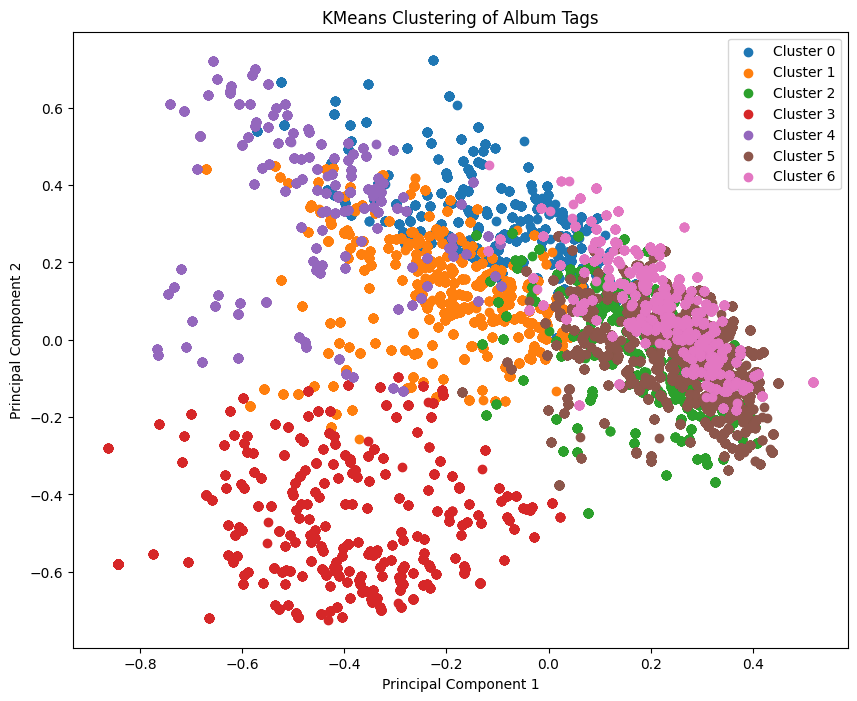

In [ ]:
# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(album_data['tag_embedding'].tolist())
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    plt.scatter(pca_result[album_data['cluster'] == i, 0], pca_result[album_data['cluster'] == i, 1], label=f'Cluster {i}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering of Album Tags')
plt.legend()
plt.show()

In [ ]:
def print_random_songs_from_clusters(albums_df, num_clusters, num_songs=10):
    #Prints a specified number of random songs from each cluster


    for i in range(num_clusters):
        cluster_songs = albums_df[albums_df['cluster'] == i]

        random_indices = random.sample(range(len(cluster_songs)), min(num_songs, len(cluster_songs)))
        print(f"Cluster {i}:")
        for index in random_indices:
          print(cluster_songs.iloc[index]['tracks'])
        print("-" * 20)

print_random_songs_from_clusters(album_data, num_clusters)

Cluster 0:
Everything Means Nothing to Me
Symphony (feat. Zara Larsson) [Lodato & Joseph Duveen Remix]
Turn The Lights Off
Always Like This
Chelsea Dagger
Aoi, Koi, Daidai-iro no Hibi
Fire Rides - Night Version
Interlude III
Oh Yeah
Field Trip
--------------------
Cluster 1:
Dystopian Overture
Exploding/Reloading
Life on Mars?
The Lines in My Hand
Ze mną się bracie nie napijesz
Gigantic
Oh My Golly!
Out Of My Head
Evening (Remastered 2006)
Sex Type Thing - Live At Castaic Lake Natural Amphitheater, 7/2/93
--------------------
Cluster 2:
Biwak
La Infinita
Herz auf
Border Lines Pt. 1
Lebanese Blonde
It Was...
Strobe (DJ Marky & S.P.Y. Remix)
This S'it Will Fcuk You Up
Can You Really Call This A Hotel, I Didn't Receive A Mint On My Pillow Or Anything
Jericho
--------------------
Cluster 3:
Damage, Inc. (Live at The Country Club, Reseda, CA - November 8th, 1986)
Shat Out of Hell
Coil
Intolerance
The Chase Is Better Than the Catch
Jealousy
The Smoke of Her Burning
Say That You Will
Carnivor

In [ ]:
def find_closest_song(albums_df, target_song):
    # Find the target song in the DataFrame
    target_song_index = albums_df[albums_df['tracks'].str.contains(target_song, na=False)].index

    if not target_song_index.empty:
        target_song_embedding = albums_df.loc[target_song_index[0], 'tag_embedding']

        # Calculate cosine similarity between the target song and all other songs
        similarities = []
        for index, row in albums_df.iterrows():
          try:
              similarity = cosine_similarity([target_song_embedding], [row['tag_embedding']])[0][0]
          except ValueError as e:
            similarity = 0.0
          similarities.append(similarity)

        # Exclude the target song itself from the similarity calculation
        similarities[target_song_index[0]] = -1

        # Find the index of the song with the highest similarity
        closest_song_index = np.argmax(similarities)

        # Return the name of the closest song
        return albums_df.iloc[closest_song_index]['tracks']
    else:
        return None


target_song = "Kiss Me On My Neck"
closest_song = find_closest_song(album_data, target_song)

if closest_song:
    print(f"The closest song to '{target_song}' is: {closest_song}")
else:
    print(f"Song '{target_song}' not found in the dataset.")

The closest song to 'Kiss Me On My Neck' is: Penitentiary Philosophy


In [ ]:
def print_top_songs_per_cluster(albums_df, num_songs=5):
    # Calculate the 99th percentile of playcount
    percentile_99 = albums_df['playcount'].quantile(0.99)
    print(f"99th Percentile Playcount: {percentile_99}")

    # Filter for songs in the top 1%
    top_1_percent = albums_df[albums_df['playcount'] >= percentile_99]


    for cluster_id in top_1_percent['cluster'].unique():
        cluster_songs = top_1_percent[top_1_percent['cluster'] == cluster_id]

        # Sort by playcount in descending order and take the top 'num_songs'
        top_songs = cluster_songs.sort_values(by='playcount', ascending=False).head(num_songs)

        print(f"\nTop {num_songs} songs in Cluster {cluster_id}:")
        for index, row in top_songs.iterrows():
            print(f"- {row['tracks']} (Playcount: {row['playcount']})")


print_top_songs_per_cluster(album_data)

99th Percentile Playcount: 65759215.0

Top 5 songs in Cluster 2:
- One More Time (Playcount: 85024496)
- Aerodynamic (Playcount: 85024496)
- Digital Love (Playcount: 85024496)
- Harder, Better, Faster, Stronger (Playcount: 85024496)
- Crescendolls (Playcount: 85024496)

Top 5 songs in Cluster 5:
- Yes or No (Playcount: 209564604)
- Closer to You (feat. Major Lazer) (Playcount: 209564604)
- Seven (feat. Latto) (Explicit Ver.) (Playcount: 209564604)
- Standing Next To You (Playcount: 209564604)
- 3D (feat. Jack Harlow) (Playcount: 209564604)

Top 5 songs in Cluster 0:
- I Will (Playcount: 76958244)
- Townie (Playcount: 76958244)
- Texas Reznikoff (Playcount: 76958244)
- Carry Me Out (Playcount: 76958244)
- Last Words of a Shooting Star (Playcount: 76958244)

Top 5 songs in Cluster 1:
- Speak to Me (Playcount: 69696134)
- Breathe (In the Air) (Playcount: 69696134)
- On the Run (Playcount: 69696134)
- Time (Playcount: 69696134)
- The Great Gig in the Sky (Playcount: 69696134)

Top 5 songs 

# Model 6 Graph Embedding on tags, tracks and artist
### In this model, a graph is constructed using features such as tags, tracks, and artists. Node2Vec is then applied to the track nodes to generate embeddings that capture the relationships and similarities between tracks

In [ ]:
def create_network(albums_df, artists_df):

    graph = nx.Graph()
    albums_df['tracks'] = albums_df['tracks'].astype(str)
    # Add nodes for tags
    for tags in albums_df['tags']:
        for tag in tags.replace('[', '').replace(']', '').replace("'", '').split(', '):
            tag = tag.strip()
            if tag:
                graph.add_node(tag, type='tag')

    for tracks in albums_df['tracks']:
        graph.add_node(tracks, type='track')

    for tags in artists_df['tags']:
        for tag in tags.replace('[', '').replace(']', '').replace("'", '').split(', '):
            tag = tag.strip()
            if tag:
                graph.add_node(tag, type='tag')


    # Add nodes for artists and albums and connect them to tags
    for index, row in albums_df.iterrows():
        album_name = row['album'].lower()
        track_name = row['tracks'].lower()
        artist_name = row['artist'].lower()
        tags = row['tags'].replace('[', '').replace(']', '').replace("'", '').split(', ')
        graph.add_node(album_name, type='album')
        graph.add_edge(album_name, artist_name)
        graph.add_edge(track_name, artist_name)
        graph.add_edge(track_name, album_name)

        for tag in tags:
            tag = tag.strip().lower()
            if tag:
                graph.add_edge(track_name, tag)

    for index, row in artists_df.iterrows():
        artist_name = row['Name'].lower()
        tags = row['tags'].replace('[', '').replace(']', '').replace("'", '').split(', ')

        #Ensure artist node is added
        if not graph.has_node(artist_name):
            graph.add_node(artist_name, type='artist')

        for tag in tags:
            tag = tag.strip()
            if tag:
                graph.add_edge(artist_name, tag)

    return graph

music_network = create_network(album_data, artist_data)

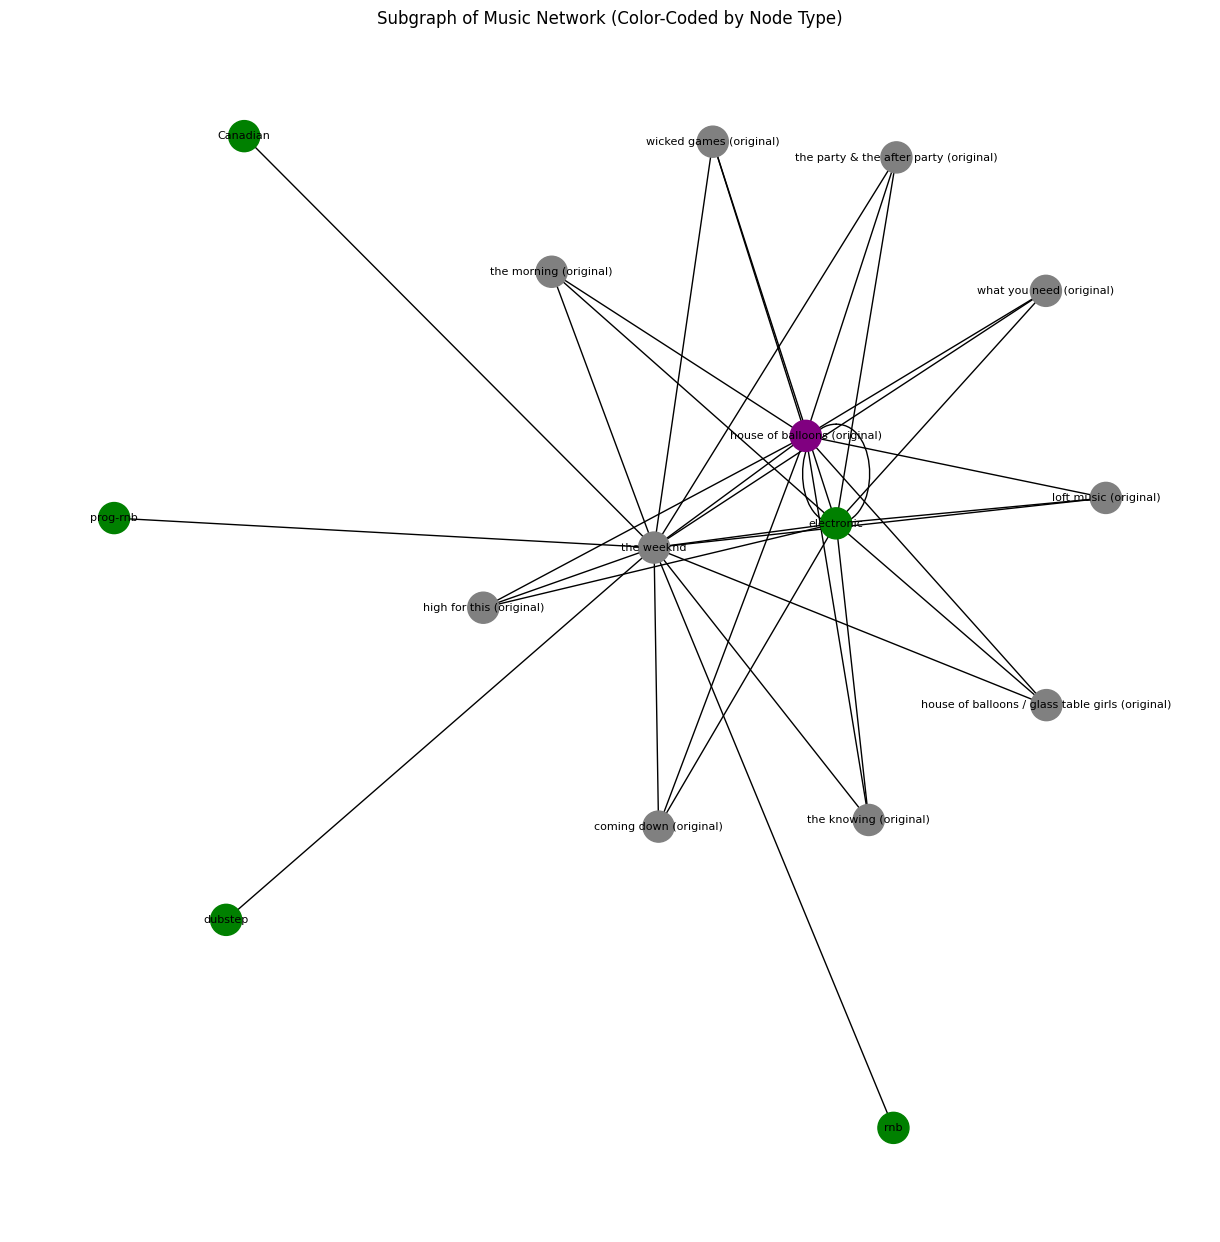

In [ ]:
subset_nodes = ['the weeknd']
for node in music_network.neighbors('the weeknd'):
    subset_nodes.append(node)

# Create a subgraph with the selected nodes and their connections
subset_graph = music_network.subgraph(subset_nodes)

# Assign colors based on node type
node_colors = []
for node in subset_graph.nodes:
    node_type = subset_graph.nodes[node].get('type', 'unknown')
    if node_type == 'artist':
        node_colors.append('red')
    elif node_type == 'track':
        node_colors.append('blue')
    elif node_type == 'tag':
        node_colors.append('green')
    elif node_type == 'album':
        node_colors.append('purple')
    else:
        node_colors.append('gray')

# Draw the subgraph with color-coded nodes
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subset_graph)
nx.draw(
    subset_graph,
    pos,
    with_labels=True,
    node_size=500,
    node_color=node_colors,
    font_size=8
)
plt.title("Subgraph of Music Network (Color-Coded by Node Type)")
plt.savefig("music_network_subgraph.png")
plt.show()


In [ ]:
!pip install node2vec

In [ ]:
from node2vec import Node2Vec
node2vec = Node2Vec(music_network, dimensions=10, walk_length=5, num_walks=5, workers=1)
model = node2vec.fit(window=2, min_count=1, batch_words=1)


Computing transition probabilities:   0%|          | 0/67247 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:58<00:00, 11.75s/it]


In [ ]:
# Function to get embedding for a song
def get_song_embedding(song_name, model):
    try:
        return model.wv[song_name.lower()]  # Use .lower() for consistency
    except KeyError:
        print(f"Warning: Embedding not found for song '{song_name}'. Returning a zero vector.")
        return np.zeros(model.wv.vector_size)

# Apply the function to each song in the DataFrame
album_data['node2vec_embedding'] = album_data['tracks'].apply(lambda x: get_song_embedding(x, model))

# Now the 'albums_df' DataFrame contains a new column 'node2vec_embedding' with the embeddings.
album_data.head()

,artist,album,mbid,listeners,playcount,tracks,tags,similar_tracks,node2vec_embedding
0,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Duvet,"['anime', 'serial experiments lain', 'british'...","Komm, Susser Tod (M-10 Director's Edit Version...","[-0.042668004, -0.28086787, 0.18756276, -0.067..."
1,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Twilight,"['anime', 'serial experiments lain', 'british'...","Elephant, Deeply, Brand New City, Advice, Just...","[0.035562072, -0.270466, 0.46743613, -0.321749..."
2,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Fool,"['anime', 'serial experiments lain', 'british'...","Rain, Scoring","[-0.015142277, -0.32868096, 0.25253737, -0.023..."
3,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Rain,"['anime', 'serial experiments lain', 'british'...","Scoring, Fool","[-0.37775832, -0.03058512, 0.8533315, -0.37169..."
4,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Elephant,"['anime', 'serial experiments lain', 'british'...","Rain, Fool","[-0.2885382, -0.37315255, 0.3293782, -0.052327..."


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_closest_songs(albums_df, target_song, top_n=5):
    """
    Finds the top_n closest songs to the target song based on cosine similarity of node2vec embeddings.

    Args:
        albums_df: DataFrame containing album information, including 'tracks' and 'node2vec_embedding'.
        target_song: The name of the target song.
        top_n: The number of closest songs to return.

    Returns:
        A list of tuples, where each tuple contains the name of a song and its cosine similarity to the target song.
        Returns an empty list if the target song is not found or if there's an error.
    """

    try:
        # Find the target song in the DataFrame
        target_song_index = albums_df[albums_df['tracks'].str.contains(target_song, na=False)].index
        if target_song_index.empty:
            # print(f"Song '{target_song}' not found in the dataset.")
            return []

        target_song_embedding = albums_df.loc[target_song_index[0], 'node2vec_embedding']

        # Calculate cosine similarity between the target song and all other songs
        similarities = []
        for index, row in albums_df.iterrows():
            try:
                similarity = cosine_similarity([target_song_embedding], [row['node2vec_embedding']])[0][0]
                similarities.append((row['tracks'], similarity))
            except ValueError as e:
                print(f"Error calculating similarity for song {row['tracks']}: {e}")
                similarities.append((row['tracks'], 0.0))  # Assign 0 similarity in case of error


        # Sort songs by similarity in descending order
        similarities.sort(key=lambda x: x[1], reverse=True)

        # Exclude the target song itself
        closest_songs = [song for song in similarities if song[0] != target_song][:top_n]

        return closest_songs
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Example usage
target_song = "Kiss Me On My Neck" # Example song
closest_songs = find_closest_songs(album_data, target_song)

if closest_songs:
    print(f"The {len(closest_songs)} closest songs to '{target_song}' are:")
    for song, similarity in closest_songs:
        print(f"- {song} (Similarity: {similarity:.4f})")

The 5 closest songs to 'Kiss Me On My Neck' are:
- Kiss Me On My Neck (Hesi) (Similarity: 1.0000)
- I'm Scared (Similarity: 0.9967)
- ...& On (Similarity: 0.9958)
- Coastal Love (Similarity: 0.9944)
- Didn't Cha Know (Similarity: 0.9944)


In [ ]:

track_vectors = album_data['node2vec_embedding'].tolist()
# Perform KMeans clustering with k=7
kmeans = KMeans(n_clusters=7, random_state=0, n_init=10)
kmeans.fit(track_vectors)

# Add cluster labels to the DataFrame
album_data['track_cluster'] = kmeans.labels_

# Print the updated DataFrame with cluster assignments
album_data.head()

,artist,album,mbid,listeners,playcount,tracks,tags,similar_tracks,node2vec_embedding,track_cluster
0,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Duvet,"['anime', 'serial experiments lain', 'british'...","Komm, Susser Tod (M-10 Director's Edit Version...","[-0.042668004, -0.28086787, 0.18756276, -0.067...",1
1,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Twilight,"['anime', 'serial experiments lain', 'british'...","Elephant, Deeply, Brand New City, Advice, Just...","[0.035562072, -0.270466, 0.46743613, -0.321749...",6
2,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Fool,"['anime', 'serial experiments lain', 'british'...","Rain, Scoring","[-0.015142277, -0.32868096, 0.25253737, -0.023...",1
3,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Rain,"['anime', 'serial experiments lain', 'british'...","Scoring, Fool","[-0.37775832, -0.03058512, 0.8533315, -0.37169...",2
4,bôa,Twilight,311ad921-98dc-43d5-ad37-ceba57618f52,1284128,41634675,Elephant,"['anime', 'serial experiments lain', 'british'...","Rain, Fool","[-0.2885382, -0.37315255, 0.3293782, -0.052327...",1


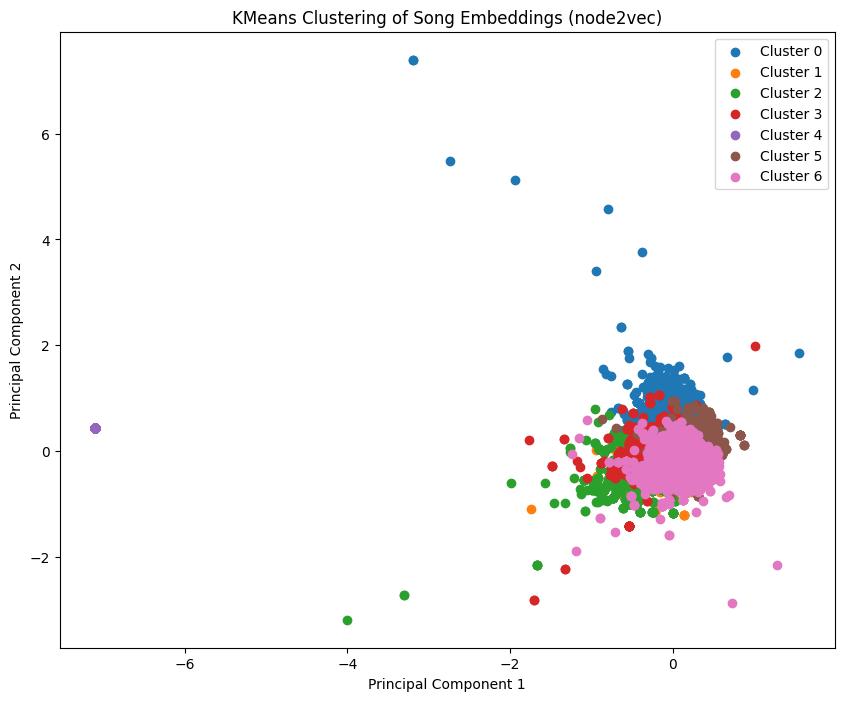

In [ ]:
# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(album_data['node2vec_embedding'].tolist())

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 8))
for i in range(7):
    plt.scatter(pca_result[album_data['track_cluster'] == i, 0], pca_result[album_data['track_cluster'] == i, 1], label=f'Cluster {i}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering of Song Embeddings (node2vec)')
plt.legend()
plt.savefig("kmeans_clustering_node2vec.png")
plt.show()

In [ ]:
def evaluate_closest_song(albums_df):
    correct_predictions = 0
    total_predictions = 0

    for index, row in albums_df[:100].iterrows():
        target_song = row['tracks'].replace('(', '').replace(')', '')
        similar_tracks = row['similar_tracks']

        if pd.notna(similar_tracks):
          closest_songs = find_closest_songs(albums_df, target_song, top_n=1)

          if closest_songs:
              closest_song = closest_songs[0][0]

              if closest_song in similar_tracks:
                  correct_predictions += 1

              total_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

accuracy = evaluate_closest_song(album_data)
print(f"Accuracy of closest song prediction: {accuracy:.4f}")

Accuracy of closest song prediction: 0.0217


In [ ]:
target_song = "Kiss Me On My Neck"
closest_song = find_closest_songs(album_data, target_song)

if closest_song:
    print(f"The closest song to '{target_song}' is: {closest_song}")
else:
    print(f"Song '{target_song}' not found in the dataset.")

The closest song to 'Kiss Me On My Neck' is: [('Kiss Me On My Neck (Hesi)', 0.9999999), ("I'm Scared", 0.9967067), ('...& On', 0.99577636), ('Coastal Love', 0.99435574), ("Didn't Cha Know", 0.99435186)]


In [ ]:
# prompt: give me 3 random songs from each cluster

def print_random_songs_from_clusters(albums_df, num_clusters, num_songs=3):
    """Prints a specified number of random songs from each cluster.

    Args:
        albums_df: DataFrame containing album information and cluster assignments.
        num_clusters: The total number of clusters.
        num_songs: The number of random songs to print from each cluster.
    """

    for i in range(num_clusters):
        cluster_songs = albums_df[albums_df['track_cluster'] == i]
        if not cluster_songs.empty:  # Check if the cluster has any songs
            random_indices = random.sample(range(len(cluster_songs)), min(num_songs, len(cluster_songs)))
            print(f"Cluster {i}:")
            for index in random_indices:
                print(cluster_songs.iloc[index]['tracks'])  # Assuming 'name' column contains song names
        else:
            print(f"Cluster {i} is empty.")
        print("-" * 20)

print_random_songs_from_clusters(album_data, 7, 3)

Cluster 0:
Towards Babylon
Guitar Solo (Fan Recording - Live at Solnahallen, Stockholm, Sweden - September 26th, 1986)
Five Months
--------------------
Cluster 1:
Leb' die Sekunde
Ao Meu Verdadeiro Amor
Golden Cage
--------------------
Cluster 2:
Blackout
My Name Is (Instrumental)
Don't Call Again
--------------------
Cluster 3:
Carmina Burana: O Fortuna
Art Decade (2017 remaster)
Hymne A L'Amour
--------------------
Cluster 4:
nan
nan
nan
--------------------
Cluster 5:
My Heart's to Blame
Something to Believe In
The Guns of Brixton
--------------------
Cluster 6:
Blackfield
These Foolish Things (Remind Me Of You)
Gravity
--------------------
